# LSST AGN Data Challenge 2021

This notebook presents Gordon Richards' 'solution' to the 2021 LSSTC AGN Data Challenge.  Although really it is more like exploratory data analysis to learn how to use the system and the data model on the way to coming up with a solution sometime in the next year.
 

In this first part, we use data from Stripe 82 where there are time domain data to populate the variable summary statistics in the Object table.   See [LC features](https://github.com/RichardsGroup/AGN_DataChallenge/blob/main/docs/04_LC_features.ipynb) for a description of how those variability summary statistics were derived.

The following software will need to be installed in order to run the notebook:
    
pip install "pandas>1.1.3"

pip install palettable

### Load software

In [3]:
## commonly used modules
import pandas as pd
print(pd.__version__)
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import os, sys
import yaml
import seaborn as sea
from scipy import stats

pd.set_option('display.max_columns', 999)

1.1.3


In [4]:
#Later we will need these
import tensorflow as tf
from tensorflow import keras
print(tf.__version__)
print(keras.__version__)

2.3.0
2.4.0


### Set data directory to point to the 2021 AGN Data Challenge data

In [5]:
data_dir = "/home/idies/workspace/Temporary/ywx649999311/LSST_AGN/Class_Training/DC/"

### Read the 'Object' table

In [6]:
#Stripe82
object_df = pd.read_parquet(os.path.join(data_dir, 's82ObjectTable.parquet'))
object_df.head(3)

,ra,dec,psPm_ra,psPm_dec,psParallax,psFlux_u,psFlux_g,psFlux_r,psFlux_i,psFlux_z,psFlux_y,psFluxErr_u,psFluxErr_g,psFluxErr_r,psFluxErr_i,psFluxErr_z,psFluxErr_y,bdFlux_u,bdFlux_g,bdFlux_r,bdFlux_i,bdFlux_z,bdFlux_y,bdFluxErr_u,bdFluxErr_g,bdFluxErr_r,bdFluxErr_i,bdFluxErr_z,bdFluxErr_y,psMag_u,psMag_g,psMag_r,psMag_i,psMag_z,psMag_y,psMagErr_u,psMagErr_g,psMagErr_r,psMagErr_i,psMagErr_z,psMagErr_y,bdMag_u,bdMag_g,bdMag_r,bdMag_i,bdMag_z,bdMag_y,bdMagErr_u,bdMagErr_g,bdMagErr_r,bdMagErr_i,bdMagErr_z,bdMagErr_y,extendedness_u,extendedness_g,extendedness_r,extendedness_i,extendedness_z,extendedness_y,stdColor_0,stdColor_1,stdColor_2,stdColor_3,stdColor_4,stdColorErr_0,stdColorErr_1,stdColorErr_2,stdColorErr_3,stdColorErr_4,class,photoZ_pest,z,flags_u,flags_g,flags_r,flags_i,flags_z,flags_y,lcPeriodic[0]_g,lcPeriodic[0]_r,lcPeriodic[0]_i,lcPeriodic[1]_g,lcPeriodic[1]_r,lcPeriodic[1]_i,lcPeriodic[2]_g,lcPeriodic[2]_r,lcPeriodic[2]_i,lcPeriodic[3]_g,lcPeriodic[3]_r,lcPeriodic[3]_i,lcPeriodic[4]_u,lcPeriodic[4]_g,lcPeriodic[4]_r,lcPeriodic[4]_i,lcPeriodic[4]_z,lcPeriodic[5]_u,lcPeriodic[5]_g,lcPeriodic[5]_r,lcPeriodic[5]_i,lcPeriodic[5]_z,lcPeriodic[6]_u,lcPeriodic[6]_g,lcPeriodic[6]_r,lcPeriodic[6]_i,lcPeriodic[6]_z,lcPeriodic[7]_u,lcPeriodic[7]_g,lcPeriodic[7]_r,lcPeriodic[7]_i,lcPeriodic[7]_z,lcPeriodic[8]_u,lcPeriodic[8]_g,lcPeriodic[8]_r,lcPeriodic[8]_i,lcPeriodic[8]_z,lcPeriodic[9]_u,lcPeriodic[9]_g,lcPeriodic[9]_r,lcPeriodic[9]_i,lcPeriodic[9]_z,lcPeriodic[10]_u,lcPeriodic[10]_g,lcPeriodic[10]_r,lcPeriodic[10]_i,lcPeriodic[10]_z,lcPeriodic[11]_u,lcPeriodic[11]_g,lcPeriodic[11]_r,lcPeriodic[11]_i,lcPeriodic[11]_z,lcPeriodic[12]_u,lcPeriodic[12]_g,lcPeriodic[12]_r,lcPeriodic[12]_i,lcPeriodic[12]_z,lcPeriodic[13]_u,lcPeriodic[13]_g,lcPeriodic[13]_r,lcPeriodic[13]_i,lcPeriodic[13]_z,lcPeriodic[14]_u,lcPeriodic[14]_g,lcPeriodic[14]_r,lcPeriodic[14]_i,lcPeriodic[14]_z,lcPeriodic[15]_u,lcPeriodic[15]_g,lcPeriodic[15]_r,lcPeriodic[15]_i,lcPeriodic[15]_z,lcPeriodic[16]_u,lcPeriodic[16]_g,lcPeriodic[16]_r,lcPeriodic[16]_i,lcPeriodic[16]_z,lcPeriodic[17]_u,lcPeriodic[17]_g,lcPeriodic[17]_r,lcPeriodic[17]_i,lcPeriodic[17]_z,lcPeriodic[18]_u,lcPeriodic[18]_g,lcPeriodic[18]_r,lcPeriodic[18]_i,lcPeriodic[18]_z,lcPeriodic[19]_u,lcPeriodic[19]_g,lcPeriodic[19]_r,lcPeriodic[19]_i,lcPeriodic[19]_z,lcPeriodic[20]_u,lcPeriodic[20]_g,lcPeriodic[20]_r,lcPeriodic[20]_i,lcPeriodic[20]_z,lcPeriodic[21]_u,lcPeriodic[21]_g,lcPeriodic[21]_r,lcPeriodic[21]_i,lcPeriodic[21]_z,lcPeriodic[22]_u,lcPeriodic[22]_g,lcPeriodic[22]_r,lcPeriodic[22]_i,lcPeriodic[22]_z,lcPeriodic[23]_u,lcPeriodic[23]_g,lcPeriodic[23]_r,lcPeriodic[23]_i,lcPeriodic[23]_z,lcPeriodic[24]_u,lcPeriodic[24]_g,lcPeriodic[24]_r,lcPeriodic[24]_i,lcPeriodic[24]_z,lcPeriodic[25]_u,lcPeriodic[25]_g,lcPeriodic[25]_r,lcPeriodic[25]_i,lcPeriodic[25]_z,lcPeriodic[26]_u,lcPeriodic[26]_g,lcPeriodic[26]_r,lcPeriodic[26]_i,lcPeriodic[26]_z,lcPeriodic[27]_u,lcPeriodic[27]_g,lcPeriodic[27]_r,lcPeriodic[27]_i,lcPeriodic[27]_z,lcPeriodic[28]_u,lcPeriodic[28]_g,lcPeriodic[28]_r,lcPeriodic[28]_i,lcPeriodic[28]_z,lcPeriodic[29]_u,lcPeriodic[29]_g,lcPeriodic[29]_r,lcPeriodic[29]_i,lcPeriodic[29]_z,lcPeriodic[30]_u,lcPeriodic[30]_g,lcPeriodic[30]_r,lcPeriodic[30]_i,lcPeriodic[30]_z,lcPeriodic[31]_u,lcPeriodic[31]_g,lcPeriodic[31]_r,lcPeriodic[31]_i,lcPeriodic[31]_z,lcPeriodic[32]_u,lcPeriodic[32]_g,lcPeriodic[32]_r,lcPeriodic[32]_i,lcPeriodic[32]_z,lcNonPeriodic[0]_u,lcNonPeriodic[0]_g,lcNonPeriodic[0]_r,lcNonPeriodic[0]_i,lcNonPeriodic[0]_z,lcNonPeriodic[1]_u,lcNonPeriodic[1]_g,lcNonPeriodic[1]_r,lcNonPeriodic[1]_i,lcNonPeriodic[1]_z,lcNonPeriodic[2]_u,lcNonPeriodic[2]_g,lcNonPeriodic[2]_r,lcNonPeriodic[2]_i,lcNonPeriodic[2]_z,lcNonPeriodic[3]_u,lcNonPeriodic[3]_g,lcNonPeriodic[3]_r,lcNonPeriodic[3]_i,lcNonPeriodic[3]_z,lcNonPeriodic[4]_u,lcNonPeriodic[4]_g,lcNonPeriodic[4]_r,lcNonPeriodic[4]_i,lcNonPeriodic[4]_z,lcNonPeriodic[5]_u,lcNonPeriodic[5]_g,lcNonPeriodic[5]_r,lcNonPeriodic[5]_i,lcNonPeriodic[5]_z,lcNo

### Identify a subsample for analysis

Let's see what features there are and how many non-null entries there are for each

In [7]:
object_df.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Index: 436990 entries, 0271386 to 1468021
Data columns (total 380 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ra                   436990 non-null  float64
 1   dec                  436990 non-null  float64
 2   psPm_ra              432795 non-null  float64
 3   psPm_dec             432795 non-null  float64
 4   psParallax           133393 non-null  float64
 5   psFlux_u             376601 non-null  float64
 6   psFlux_g             423564 non-null  float64
 7   psFlux_r             425728 non-null  float64
 8   psFlux_i             425206 non-null  float64
 9   psFlux_z             426094 non-null  float64
 10  psFlux_y             381635 non-null  float64
 11  psFluxErr_u          376601 non-null  float64
 12  psFluxErr_g          423564 non-null  float64
 13  psFluxErr_r          425728 non-null  float64
 14  psFluxErr_i          425206 non-null  float64
 15  psFluxErr_z   

Let's make a subset of features that have data.  We cut `photoZ_pest` as those are only available for galaxies.  Also 'flags_?' as an initial pass through the random forest unsuprisingly identifies those as having no importance.

Note that the variability parameters have been populated as explained here:
https://github.com/RichardsGroup/AGN_DataChallenge/blob/main/docs/04_LC_features.ipynb

In [8]:
object_short_df = object_df.drop(
    ['photoZ_pest', 'flags_u', 'flags_g', 'flags_r', 
     'flags_i', 'flags_z', 'flags_y'
    ], axis=1)

 Cut all rows that have any missing features.  We could instead inpute the values, but this is fine for now as we have enough data.

In [9]:
good_df = object_short_df.dropna()

Let's also change "coordinates" of the DHO parameters and phrase them in terms of timescales instead.  The next 2 cells are the necessary code from Weixiang Yu.  The third cell does the conversion and adds these parameters to the Pandas Dataframe.

In [9]:
def dho_timescales(params):
    """Compute a couple DHO timescales from CARMA parameters.
    - damping factor
    - decay timescale
    - rise/damped QPO timescale
    - perturbation timescale
    - decorrelation timescale
    - natural oscillation frequency
    """
    
    # expand params
    a1, a2, b0, b1 = params
    
    # damping factor & natural frequency
    xi = a1/(2*np.sqrt(a2))
    omega_0 = np.sqrt(a2)
    
    # placeholder for two timescales
    tau_perturb = b1/b0
    tau_decay = 0
    tau_rise_dqpo = 0
    tau_decorr = 0
    
    roots = np.roots([1, a1, a2])
    if xi < 1:
        tau_decay = np.abs(1/roots[0].real)
        tau_rise_dqpo = 2*np.pi*np.abs(1/roots[0].imag)/np.sqrt(1 - xi**2)
        tau_decorr = tau_rise_dqpo*np.pi/2
    else:
        tau_decay = np.abs(1/np.max(roots.real))
        tau_rise_dqpo = np.abs(1/np.min(roots.real))
        tau_decorr = (tau_decay + tau_rise_dqpo)*np.pi/2

    return np.array([xi, tau_decay, tau_rise_dqpo, tau_perturb, tau_decorr, omega_0])

vec_dho_timescales = np.vectorize(dho_timescales, signature='(m)->(n)')

In [10]:
def compute_b0b1(a1, a2, tau, amp=1):
    """Compute b0, b1 given a1, a2, tau_perturb and amplitude"""
    b0 = np.sqrt(2*amp**2*a1*a2/(a2*tau**2+1))
    b1 = b0*tau
    return b0, b1

In [11]:
#Rephrase the DHO timescales in term of physical parameters.
dho_a1 = 'lcPeriodic[0]_i'
dho_a2 = 'lcPeriodic[1]_i'
dho_b0 = 'lcPeriodic[2]_i'
dho_b1 = 'lcPeriodic[3]_i'

#Add DHO parameters derived from those fields and drop NaNs.
good_df = good_df.dropna(subset=[dho_a1, dho_a2, dho_b0, dho_b1])
qso_timescales = vec_dho_timescales(good_df[[dho_a1, dho_a2, dho_b0, dho_b1]].values)
good_df.loc[:, ['xi', 'tau_decay', 'tau_rise_dqpo', 'tau_perturb', 'tau_decorr', 'omega_0']] = qso_timescales

#Add the amplitude of the DHO
good_df['amp'] = np.sqrt((good_df[dho_b1]**2*good_df[dho_a2] + good_df[dho_b0]**2)/(2* good_df[dho_a1]*good_df[dho_a2]))

In [14]:
good_df.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Index: 60824 entries, 0271390 to 1467484
Data columns (total 373 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ra                   60824 non-null  float64
 1   dec                  60824 non-null  float64
 2   psPm_ra              60824 non-null  float64
 3   psPm_dec             60824 non-null  float64
 4   psParallax           60824 non-null  float64
 5   psFlux_u             60824 non-null  float64
 6   psFlux_g             60824 non-null  float64
 7   psFlux_r             60824 non-null  float64
 8   psFlux_i             60824 non-null  float64
 9   psFlux_z             60824 non-null  float64
 10  psFlux_y             60824 non-null  float64
 11  psFluxErr_u          60824 non-null  float64
 12  psFluxErr_g          60824 non-null  float64
 13  psFluxErr_r          60824 non-null  float64
 14  psFluxErr_i          60824 non-null  float64
 15  psFluxErr_z          60824 non-n

How many different classes do we have and how many in each class?

In [15]:
class_names, counts = np.unique(good_df['class'].values, return_counts=True)
dict(zip(class_names, counts))

{'Agn': 8, 'Gal': 83, 'Qso': 10145, 'Star': 50588}

Since there aren't many objects in this subset that are classified as AGN or Gal, let's cut those objects and focus on separating quasars from stars.

In [16]:
final_df = good_df.loc[(good_df['class'] != 'Agn') & (good_df['class'] != 'Gal')]

### Convert to format that Scikit Learn wants.

Namely the features in `X` and the answers in `y`.

Pop "answers" for classification and regression (separately).  Although this notebook will only attempt classification and not photo-z.

In [17]:
#Make a copy of final_df to use for the transfer learning experiment below.
transfer_df = final_df.copy()

In [18]:
yclass_df = final_df.pop('class')
yregress_df = final_df.pop('z')

In [19]:
X = final_df.to_numpy()
yclass = yclass_df.to_numpy()
yregress = yregress_df.to_numpy()

### Create Train/Test split

We'll train the algorithms and then use the test set to evaluate them.  

We could then apply to the blinded subset, but I don't think that this really merits that level of inspection as I haven't done anything to optimize the RF.

In [18]:
from sklearn.model_selection import train_test_split
Xclasstrain, Xclasstest, yclasstrain, yclasstest = train_test_split(X, yclass)

In [19]:
print(Xclasstrain)

[[ 2.47583460e+01 -1.21742570e+00  6.54121458e+00 ...  1.29809726e-01
   7.60313167e+01  2.68947883e+03]
 [ 2.36664580e+01  6.75568410e-01 -3.17435152e+00 ...  5.43816033e+00
   1.81487926e+00  2.40348156e+03]
 [ 9.89925680e+00 -8.08851340e-01  5.77172946e-01 ...  1.37878705e+04
   7.17067651e-04  6.71042152e+03]
 ...
 [ 3.52067840e+02 -3.57300720e-01  6.65261669e+00 ...  4.26205664e-01
   2.31569059e+01  2.16093844e+04]
 [ 1.38954780e+01  8.37136940e-01 -4.66140599e-01 ...  1.84320576e-01
   5.35458636e+01  4.71375869e+03]
 [ 4.56908250e+01 -1.28407240e-01 -1.75017724e+00 ...  1.95919178e-01
   5.03759556e+01  4.66976473e+03]]


### Classification example using Random Forests

Train a [simple random forest classifier from Scikit-Learn](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html).   Not trying to do any sort of optimization here, just looking to identify the features with the largest importances.

In [20]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=100, max_features='auto', n_jobs=-1)
rfc.fit(Xclasstrain,yclasstrain)

RandomForestClassifier(n_jobs=-1)

Nevertheless, we can use the classifier to predict the classes of the test set and at least see how well a non-optimized approach works.  Note that we are including variability and color parameters here (among other things).

In [21]:
ypredtest = rfc.predict(Xclasstest)

See results on this later after we look at the feature importances, which is the real point here.  Which of these nearly 400 features is doing most of the work?

In [22]:
feature_names = final_df.columns
importances = pd.Series(rfc.feature_importances_, index=feature_names)

In [23]:
print(importances.index.values)

['ra' 'dec' 'psPm_ra' 'psPm_dec' 'psParallax' 'psFlux_u' 'psFlux_g'
 'psFlux_r' 'psFlux_i' 'psFlux_z' 'psFlux_y' 'psFluxErr_u' 'psFluxErr_g'
 'psFluxErr_r' 'psFluxErr_i' 'psFluxErr_z' 'psFluxErr_y' 'bdFlux_u'
 'bdFlux_g' 'bdFlux_r' 'bdFlux_i' 'bdFlux_z' 'bdFlux_y' 'bdFluxErr_u'
 'bdFluxErr_g' 'bdFluxErr_r' 'bdFluxErr_i' 'bdFluxErr_z' 'bdFluxErr_y'
 'psMag_u' 'psMag_g' 'psMag_r' 'psMag_i' 'psMag_z' 'psMag_y' 'psMagErr_u'
 'psMagErr_g' 'psMagErr_r' 'psMagErr_i' 'psMagErr_z' 'psMagErr_y'
 'bdMag_u' 'bdMag_g' 'bdMag_r' 'bdMag_i' 'bdMag_z' 'bdMag_y' 'bdMagErr_u'
 'bdMagErr_g' 'bdMagErr_r' 'bdMagErr_i' 'bdMagErr_z' 'bdMagErr_y'
 'extendedness_u' 'extendedness_g' 'extendedness_r' 'extendedness_i'
 'extendedness_z' 'extendedness_y' 'stdColor_0' 'stdColor_1' 'stdColor_2'
 'stdColor_3' 'stdColor_4' 'stdColorErr_0' 'stdColorErr_1' 'stdColorErr_2'
 'stdColorErr_3' 'stdColorErr_4' 'lcPeriodic[0]_g' 'lcPeriodic[0]_r'
 'lcPeriodic[0]_i' 'lcPeriodic[1]_g' 'lcPeriodic[1]_r' 'lcPeriodic[1]_i'
 'lcPeriod

print(importances.sort_values(ascending=False).to_string())

In [24]:
top15 = importances.sort_values(ascending=False)[:15]
bottom15 = importances.sort_values(ascending=True)[:15]

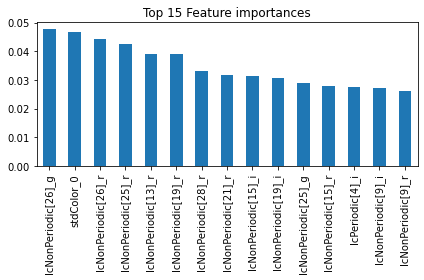

In [25]:
fig, ax = plt.subplots()
top15.plot.bar(ax=ax)
ax.set_title("Top 15 Feature importances")
fig.tight_layout()

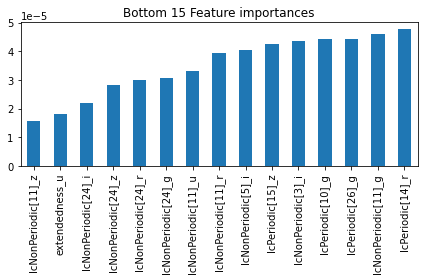

In [26]:
fig, ax = plt.subplots()
bottom15.plot.bar(ax=ax)
ax.set_title("Bottom 15 Feature importances")
fig.tight_layout()

<b>Note that these lists of top 15 and bottom 15 importances are already providing some interesting value added to the problem.</b>  That is, it isn't a solution, but it could tell use which features we might put into (or leave out of) another algorithm.

It is also interesting that the DHO parameters (lcPeriodic[0-3] and the parameters derived from them) are not more important.  However, they may be important for science moreso than classification.

---

### Determine the accuracy of the classifier

Compute and display some summary information, including the overall score, and the confusion matrix.

In [27]:
from sklearn.metrics import accuracy_score
accuracy_score(yclasstest, ypredtest)

0.9958508956796628

So, even without optimizing anything we do pretty well (at least for bright objects with known classes).

In [28]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(yclasstest, ypredtest))

[[ 2485    51]
 [   12 12636]]


Make a plot of this.

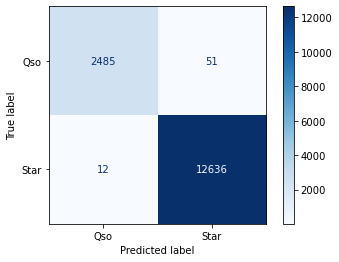

In [29]:
from sklearn.metrics import plot_confusion_matrix

class_names = np.unique(yclasstest)

plot_confusion_matrix(rfc, Xclasstest, yclasstest,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues)

### => WY: Run RF Classifier on Blinded Dataset (Stripe 82) <=

#### 1. Make the RF subset of the blinded dataset
- read the full blinded dataset from disk
- remove class Agn and Gal
- select coloumns that are in final_df (except the DHO parameters)
- drop any row that has a NaN (this also remove non-S82 objects)
- compute/add DHO features
- pop/save 'class' and 'z' columns

In [10]:
# read the blinded dataset
object_blinded_df = pd.read_parquet(os.path.join(data_dir, 'ObjectTable_Blinded.parquet'))

# remove class Agn and Gal
class_mask = (object_blinded_df['class'] != 'Agn') & (object_blinded_df['class'] != 'Gal')
blinded_rf_df = object_blinded_df[class_mask]

In [20]:
# select coloumns that are in final_df (except the DHO parameters)
dho_cols = ['xi', 'tau_decay', 'tau_rise_dqpo', 'tau_perturb', 'tau_decorr', 'omega_0', 'amp'] 
select_cols = [col for col in final_df.columns if col not in dho_cols] + ['class', 'z']
blinded_rf_df= blinded_rf_df[select_cols]

In [22]:
# drop nan
blinded_rf_df = blinded_rf_df.dropna()

# print number of objects in the final blinded test set
print(f'Total Number of objects in the final blinded test set: {len(blinded_rf_df)}')
print('Counts for each class: ')
blinded_rf_df['class'].value_counts()

Total Number of objects in the final blinded test set: 2571
Counts for each class: 


Qso     1693
Star     878
Name: class, dtype: int64

In [33]:
# compute/add DHO features
qso_timescales = vec_dho_timescales(blinded_rf_df[[dho_a1, dho_a2, dho_b0, dho_b1]].values)
blinded_rf_df.loc[:, ['xi', 'tau_decay', 'tau_rise_dqpo', 'tau_perturb', 'tau_decorr', 'omega_0']
                 ] = qso_timescales

#Add the amplitude of the DHO
blinded_rf_df.loc[blinded_rf_df.index, ['amp']] = np.sqrt(
    (blinded_rf_df[dho_b1]**2*blinded_rf_df[dho_a2] + blinded_rf_df[dho_b0]**2)/
    (2* blinded_rf_df[dho_a1]*blinded_rf_df[dho_a2])
)

In [34]:
# pop class & z -> save separately
blinded_yclass_df = blinded_rf_df.pop('class')
blinded_yregress_df = blinded_rf_df.pop('z')

In [35]:
# if column order match that of final_df, make blinded test set
if (blinded_rf_df.columns == final_df.columns).all():
    X_b = blinded_rf_df.to_numpy()
    yclass_b = blinded_yclass_df.to_numpy()
    yregress_b = blinded_yregress_df.to_numpy()

#### 2. Test the RF Classifier
- Check classification accuray
- Make confusion matrix

In [36]:
# check classification accuray 
ypred_b = rfc.predict(X_b)
a_score = accuracy_score(ypred_b, yclass_b)
print(f'Classificatio accuracy on the blinded test set: {a_score}')

Classificatio accuracy on the blinded test set: 0.9929988331388565


Text(0.5, 1.0, 'Normalized by predicted labels (purity)')

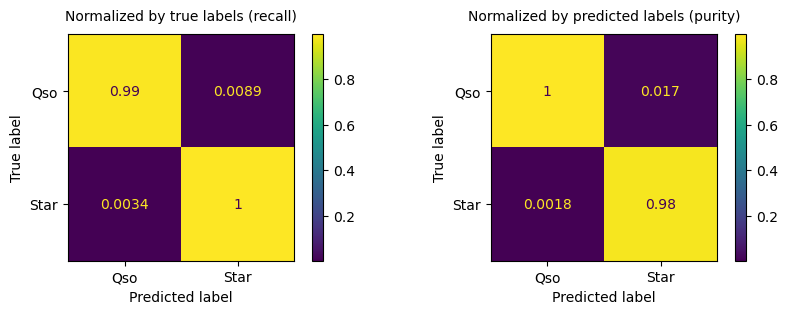

In [38]:
class_names = np.unique(yclass_b)
fig, axes = plt.subplots(1, 2, dpi=100, figsize=(10, 3))

plot_confusion_matrix(rfc, X_b, yclass_b, display_labels=class_names, 
#                       cmap=plt.cm.Blues, 
                      normalize='true', ax=axes[0])
plot_confusion_matrix(rfc, X_b, yclass_b, display_labels=class_names, 
#                       cmap=plt.cm.Blues, 
                      normalize='pred', ax=axes[1])

axes[0].set_title('Normalized by true labels (recall)', pad=10, fontsize=10)
axes[1].set_title('Normalized by predicted labels (purity)', pad=10, fontsize=10)

---

In [55]:
from sklearn.metrics import confusion_matrix
tp, fn, fp, tn = confusion_matrix(yclasstest,ypredtest).ravel()
print(tp, tn, fp, fn)

2551 12573 12 48


Let's make some masks for the above to aid in plotting.

In [56]:
tpmasktest = ((yclasstest=='Qso') & (ypredtest=='Qso'))
tnmasktest = ((yclasstest=='Star') & (ypredtest=='Star'))
fpmasktest = ((yclasstest=='Star') & (ypredtest=='Qso'))
fnmasktest = ((yclasstest=='Qso') & (ypredtest=='Star'))
print(tpmasktest.sum(),tnmasktest.sum(),fpmasktest.sum(),fnmasktest.sum())

2551 12573 12 48


We computed results for just the "test" data above, but let's also compute for both the training and test data (basically all of the final_df) dataframe objects in case we want to visualize all the data.

Indeed, if we wanted to only plot the test data, then we'd need to create a version of `final_df` that includes only the test objects.

In [31]:
#Need predictions for all
ypredall = rfc.predict(X)

In [32]:
#Make masks for the above to aid in plotting
tpmask = ((yclass=='Qso') & (ypredall=='Qso'))
tnmask = ((yclass=='Star') & (ypredall=='Star'))
fpmask = ((yclass=='Star') & (ypredall=='Qso'))
fnmask = ((yclass=='Qso') & (ypredall=='Star'))
print(tpmask.sum(),tnmask.sum(),fpmask.sum(),fnmask.sum())

10098 50578 10 47


### Make some plots

Define some plotting functions, etc.

In [33]:
#Define function that will be used to make plot similar to scatter_dot in SM

def contour_scatter(x, y, exkernel=None, ax=None, color='C0', cmap='Blues_r',
                    lims=None, levels=None, scatter=True, nlevel=1,
                    kwargs_contour={},
                    kwargs_plot={}):
    """ Contour and scatter plot with no points inside contours """


    if ax is None:
        ax = plt.gca()
    # fig, ax = plt.subplots(1)
    if lims is None:
        xmin = x.min()
        xmax = x.max()
        ymin = y.min()
        ymax = y.max()
    else:
        xmin, xmax, ymin, ymax = lims

    X, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
    positions = np.vstack([X.ravel(), Y.ravel()])
    values = np.vstack([x, y])
    kernel = stats.gaussian_kde(values)
    Z = np.reshape(kernel(positions).T, X.shape)

    CS = ax.contour(X,
                    Y,
                    Z,
                    cmap=cmap,
                    levels=levels,
                    **kwargs_contour)

    if scatter is True:
        print(CS.levels)
        threshold = CS.levels[nlevel] # nlevel=1 or 0 depending on Python version?
        z = kernel(values)

        # mask points above density threshold
        x = np.ma.array(x)
        y = np.ma.array(y)
        if exkernel:
            exz = exkernel(values)
            x[exz > threshold] = np.ma.masked
            y[exz > threshold] = np.ma.masked

        x[z > threshold] = np.ma.masked
        y[z > threshold] = np.ma.masked

        ax.scatter(x, y, color=color, **kwargs_plot)

    if exkernel is False:
        return kernel

    return ax  # x[~x.mask], y[~y.mask]

In [34]:
import palettable  #N.B.  Judges will need to install this!

#See colorbrewer2.org
#4-class PuOr
#$cmap="PuOr"
cspuor = palettable.colorbrewer.diverging.PuOr_4.mpl_colors

#4-class Dark
csdark = palettable.colorbrewer.qualitative.Dark2_4.mpl_colors

#4-class Paired
cspaired = palettable.colorbrewer.qualitative.Paired_4.mpl_colors

#6-class sequential
cspurples = palettable.colorbrewer.sequential.Purples_6.mpl_colors
csoranges = palettable.colorbrewer.sequential.Oranges_6.mpl_colors
csblues = palettable.colorbrewer.sequential.Blues_6.mpl_colors
csgreens = palettable.colorbrewer.sequential.Greens_6.mpl_colors
csreds = palettable.colorbrewer.sequential.Reds_6.mpl_colors
csgreys = palettable.colorbrewer.sequential.Greys_6.mpl_colors

In [35]:
#Setup defaults for plotting

def figsze(hscale, vscale=(np.sqrt(5.0)-1.0)/2.0, fig_width_pt = 800.0):
    """
    Get the fig_width_pt by inserting \the\textwidth into LaTeX document.

    hscale is fraction of text width you want.

    vscale is fraction of hscale (defaults to golden ratio)  
    """
   
    inches_per_pt = 1.0/72.27                       # Convert pt to inch
    fig_width = fig_width_pt*inches_per_pt*hscale   # width in inches
    fig_height = fig_width#*vscale                   # height in inches
    fig_size = [fig_width/2+2,fig_height]
    return fig_size

pgf_with_latex = {                      # setup matplotlib to use latex for output
    "axes.linewidth":1.2,               # width of box, 2 is too wide, 1 is too narrow
    "pgf.texsystem": "pdflatex",        # change this if using xetex or lautex
    "text.usetex": True,                # use LaTeX to write all text
    "font.family": "serif",
    "font.serif": [],                   # blank entries should cause plots to inherit fonts from the document
    "font.sans-serif": [],
    "font.monospace": [],
    "axes.labelsize": 24,               # LaTeX default is 10pt font, font size of axis text label
    "axes.labelpad" : 6,                # Distance between label and axis    
    "axes.formatter.limits":[-99,99],   # use sci notation if log10 of axis range is smaller than first or larger than second.
                                        # GTR: Actually *don't* -- should change the axis label instead.  E.g., "Flux Density (10^-17 ergs/s/cm^2)" 
                                        # This is a hack b/c there doesn't seem to be an rcParams version of
                                        # axes.ticklabel_format(style='plain')
    #"axes.formatter.style":"plain",    # Turn off multiplicative offsets (sci notation) to the axes [GTR: Doesn't work]
    "axes.formatter.useoffset":False,   # Turn off additive offsets to the axes
    "font.size": 24,
    "legend.fontsize": 24,              # Make the legend/label fonts a little smaller
    "xtick.labelsize": 24,              # Font size of numbers 
    "ytick.labelsize": 24,
    "xtick.direction": "in",
    "ytick.direction": "in",
    "xtick.minor.visible": True,
    "ytick.minor.visible": True,
    "xtick.major.top":True,
    "xtick.minor.top":True,
    "ytick.major.right":True,
    "ytick.minor.right":True,
    'xtick.major.width':1.0, 
    'xtick.minor.width':1.0, 
    'ytick.major.width':1.0, 
    'ytick.minor.width':1.0, 
    'xtick.major.size':8,             # size of tickmarks in points
    'xtick.minor.size':4, 
    'ytick.major.size':8, 
    'ytick.minor.size':4,
    'xtick.major.pad':8,               # distance between box and numbers
    'ytick.major.pad':8,
    "figure.figsize": figsze(1,1),     # default fig size of 0.9 textwidth
    "pgf.preamble": [
        r"\usepackage[utf8x]{inputenc}",    # use utf8 fonts because your computer can handle it
        r"\usepackage[T1]{fontenc}",        # plots will be generated using this preamble
        ]
    }

mpl.rcParams.update(pgf_with_latex)

/home/idies/miniconda3/envs/py38/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  self[key] = other[key]


Start with color-color plots of true/false positives/negatives.

[0.  0.5 1.  1.5 2.  2.5 3.  3.5 4. ]
[0.  0.3 0.6 0.9 1.2 1.5 1.8 2.1 2.4]
[ 0.   1.5  3.   4.5  6.   7.5  9.  10.5]
[0. 1. 2. 3. 4. 5. 6. 7.]
[ 0.  8. 16. 24. 32. 40. 48. 56. 64.]
[ 0.   1.5  3.   4.5  6.   7.5  9.  10.5]


findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


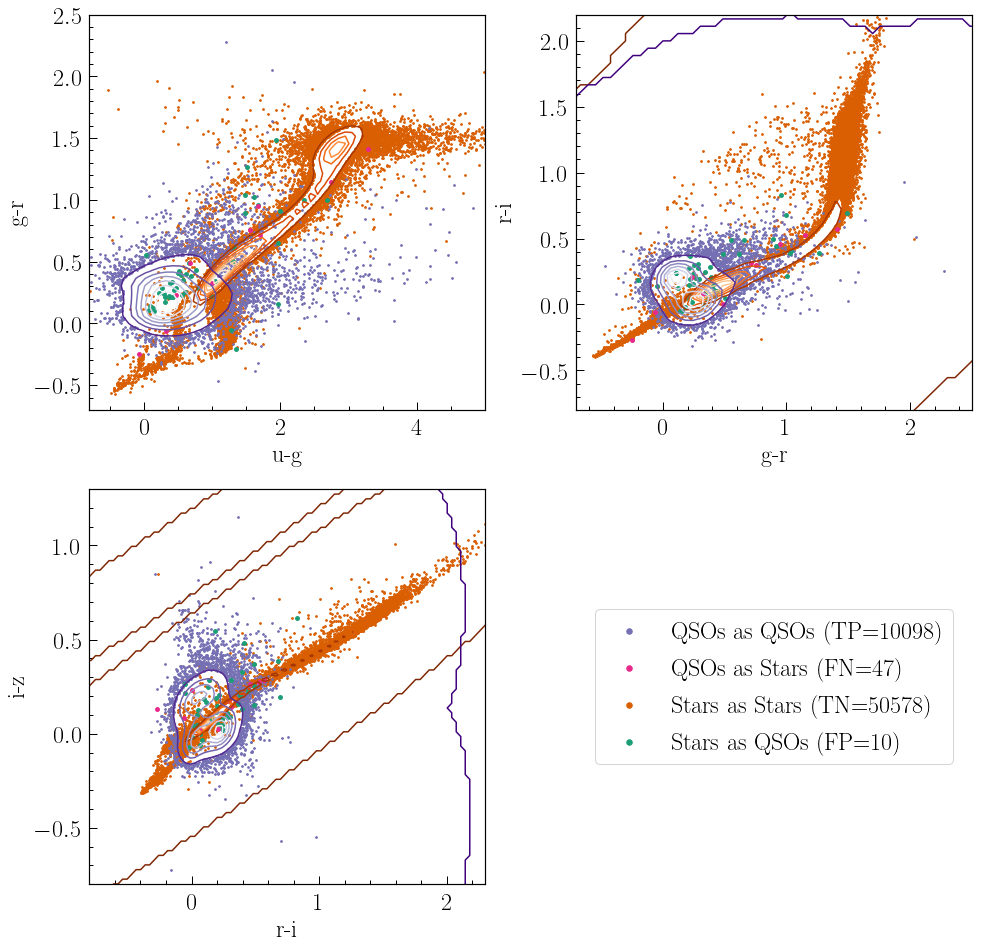

In [36]:
limsugr = np.array([[-2,8], [-2,4]])
limsugr = limsugr.flatten()
limsgri = np.array([[-2,4], [-2,3.5]])
limsgri = limsgri.flatten()
limsriz = np.array([[-1,2.5], [-1,1.5]])
limsriz = limsriz.flatten()
levels = None
nlevel=1

# Make the figure:
#fig,ax = plt.figure(figsize=(8,8))
fig, ax = plt.subplots(2,2,figsize=(16,16))


handles, labels = (0, 0)
    
for i, axis in enumerate(ax.ravel()):

    if i==0: 
        contour_scatter(final_df[tnmask]['stdColor_0'], final_df[tnmask]['stdColor_1'], lims=limsugr, levels=levels, nlevel=nlevel, cmap='Oranges_r', color=csdark[1], kwargs_plot={'rasterized':True, 's':3}, ax=axis)
        contour_scatter(final_df[tpmask]['stdColor_0'], final_df[tpmask]['stdColor_1'], lims=limsugr, levels=levels, nlevel=nlevel, cmap='Purples_r', color=csdark[2], kwargs_plot={'rasterized':True, 's':3}, ax=axis)
        #contour_scatter(final_df[fnmask]['stdColor_0'], final_df[fnmask]['stdColor_1'], lims=limsugr, levels=levels, nlevel=nlevel, cmap='Greens_r', color=csdark[0], kwargs_plot={'rasterized':True, 's':3}, ax=axis)
        #contour_scatter(final_df[fpmask]['stdColor_0'], final_df[fpmask]['stdColor_1'], lims=limsugr, levels=levels, nlevel=nlevel, cmap='Reds_r', color=csdark[3], kwargs_plot={'rasterized':True, 's':3}, ax=axis)
        axis.scatter(final_df[fnmask]['stdColor_0'], final_df[fnmask]['stdColor_1'], color=csdark[0], s=15)
        axis.scatter(final_df[fpmask]['stdColor_0'], final_df[fpmask]['stdColor_1'], color=csdark[3], s=15)
        axis.set_xlim(-0.8,5)
        axis.set_ylim(-0.7,2.5)
        axis.set_xlabel('u-g')
        axis.set_ylabel('g-r')
        axis.set_box_aspect(1)
        
    if i==1:
        contour_scatter(final_df[tnmask]['stdColor_1'], final_df[tnmask]['stdColor_2'], lims=limsgri, levels=levels, nlevel=nlevel, cmap='Oranges_r', color=csdark[1], kwargs_plot={'rasterized':True, 's':3}, ax=axis)
        contour_scatter(final_df[tpmask]['stdColor_1'], final_df[tpmask]['stdColor_2'], lims=limsgri, levels=levels, nlevel=nlevel, cmap='Purples_r', color=csdark[2], kwargs_plot={'rasterized':True, 's':3}, ax=axis)
        #contour_scatter(final_df[fnmask]['stdColor_1'], final_df[fnmask]['stdColor_2'], lims=limsgri, levels=levels, nlevel=nlevel, cmap='Greens_r', color=csdark[0], kwargs_plot={'rasterized':True, 's':3}, ax=axis)
        #contour_scatter(final_df[fpmask]['stdColor_1'], final_df[fpmask]['stdColor_2'], lims=limsgri, levels=levels, nlevel=nlevel, cmap='Reds_r', color=csdark[3], kwargs_plot={'rasterized':True, 's':3}, ax=axis)
        axis.scatter(final_df[fnmask]['stdColor_1'], final_df[fnmask]['stdColor_2'], color=csdark[0], s=15)
        axis.scatter(final_df[fpmask]['stdColor_1'], final_df[fpmask]['stdColor_2'], color=csdark[3], s=15)
        axis.set_xlim(-0.7,2.5)
        axis.set_ylim(-0.8,2.2)
        axis.set_xlabel('g-r')
        axis.set_ylabel('r-i')
        axis.set_box_aspect(1)
        
    if i==2:
        contour_scatter(final_df[tnmask]['stdColor_2'], final_df[tnmask]['stdColor_3'], lims=limsriz, levels=levels, nlevel=nlevel, cmap='Oranges_r', color=csdark[1], kwargs_plot={'rasterized':True, 's':3}, ax=axis)
        contour_scatter(final_df[tpmask]['stdColor_2'], final_df[tpmask]['stdColor_3'], lims=limsriz, levels=levels, nlevel=nlevel, cmap='Purples_r', color=csdark[2], kwargs_plot={'rasterized':True, 's':3}, ax=axis)  
        #contour_scatter(final_df[fnmask]['stdColor_2'], final_df[fnmask]['stdColor_3'], lims=limsriz, levels=levels, nlevel=nlevel, cmap='Greens_r', color=csdark[0], kwargs_plot={'rasterized':True, 's':3}, ax=axis)
        #contour_scatter(final_df[fpmask]['stdColor_2'], final_df[fpmask]['stdColor_3'], lims=limsriz, levels=levels, nlevel=nlevel, cmap='Reds_r', color=csdark[3], kwargs_plot={'rasterized':True, 's':3}, ax=axis)
        axis.scatter(final_df[fnmask]['stdColor_2'], final_df[fnmask]['stdColor_3'], color=csdark[0], s=15)
        axis.scatter(final_df[fpmask]['stdColor_2'], final_df[fpmask]['stdColor_3'], color=csdark[3], s=15)
        axis.set_xlim(-0.8,2.3)
        axis.set_ylim(-0.8,1.3)
        axis.set_xlabel('r-i')
        axis.set_ylabel('i-z')
        axis.set_box_aspect(1)

    if i==3:
        axis.set_axis_off()
        #handles = [plt.scatter([], [], color=csdark[1], s=30),plt.scatter([],[],color=csdark[2],s=30),plt.scatter([],[],color=csdark[3],s=30),plt.scatter([],[],color=csdark[0],s=50)]
        #labels  = ['Stars as Stars (TN='+str(tnmask.sum())+')', 'QSOs as QSOs (TP='+str(tpmask.sum())+')', 'QSOs as Stars (FN='+str(fnmask.sum())+')', 'Stars as QSOs (FP='+str(fpmask.sum())+')']
        handles = [plt.scatter([],[],color=csdark[2],s=30),plt.scatter([],[],color=csdark[3],s=30),plt.scatter([], [], color=csdark[1], s=30),plt.scatter([],[],color=csdark[0],s=30)]
        labels  = ['QSOs as QSOs (TP='+str(tpmask.sum())+')', 'QSOs as Stars (FN='+str(fnmask.sum())+')', 'Stars as Stars (TN='+str(tnmask.sum())+')', 'Stars as QSOs (FP='+str(fpmask.sum())+')']
        legend = axis.legend(handles, labels, loc='center')    

#plt.savefig('/home/idies/workspace/Storage/gtr/persistent/plots/MiMstarqso_varcolorsonly.png')

This looks pretty much like one would expect.  Indeed it is doing a really nice job as the WD+M stars aren't being confused for quasars.

Now see what the variability data look like.

Let's look at the features Weixiang has derived from lcPeriodic[0-3] and
both lcNonPeriodic[26] and lcNonPeriodic[15]
since those were identified as of interest above.

For now, just look at the i-band data.

In [37]:
#Look at the range of values to get some idea of appropriate plot limits (but need to take the log of these).
print(final_df['xi'].min(), final_df['xi'].max())
print(final_df['tau_decay'].min(), final_df['tau_decay'].max())
print(final_df['tau_rise_dqpo'].min(), final_df['tau_rise_dqpo'].max())
print(final_df['tau_perturb'].min(), final_df['tau_perturb'].max())
print(final_df['tau_decorr'].min(), final_df['tau_decorr'].max())
print(final_df['omega_0'].min(), final_df['omega_0'].max())
print(final_df['xi'].quantile([0.1,0.90]))
print(final_df['tau_decay'].quantile([0.1,0.9]))
print(final_df['tau_rise_dqpo'].quantile([0.1,0.9]))
print(final_df['tau_perturb'].quantile([0.1,0.9]))
print(final_df['tau_decorr'].quantile([0.1,0.9]))
print(final_df['omega_0'].quantile([0.1,0.9]))
print(final_df['amp'].quantile([0.1,0.9]))

8.459510245060065e-11 2955260699.297554
0.001158197465160793 10686473380210.129
3.0590232050182584e-07 3328688.354268409
0.00030865053256741274 339625932.21657777
0.0022341699729592863 16786273132025.512
0.0005530843701478336 1808.0424144560632
0.1    3.269567e-07
0.9    3.620070e+00
Name: xi, dtype: float64
0.1         8.049394
0.9    173691.020962
Name: tau_decay, dtype: float64
0.1    0.014228
0.9    6.798666
Name: tau_rise_dqpo, dtype: float64
0.1       0.002049
0.9    4597.107735
Name: tau_perturb, dtype: float64
0.1      0.043897
0.9    796.702626
Name: tau_decorr, dtype: float64
0.1      0.042860
0.9    225.570644
Name: omega_0, dtype: float64
0.1     1580.800996
0.9    32504.832807
Name: amp, dtype: float64


[0.   0.06 0.12 0.18 0.24 0.3  0.36 0.42]
[0.   0.15 0.3  0.45 0.6  0.75 0.9  1.05]


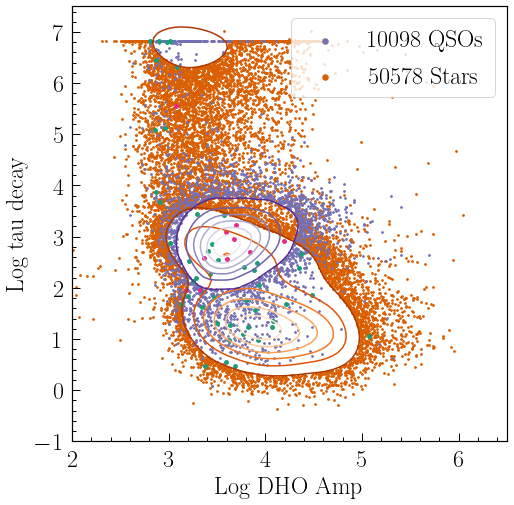

In [38]:
lims = np.array([[1,7], [-2,8]])
lims = lims.flatten()
levels = None
nlevel=1

fig, axis = plt.subplots(1,1,figsize=(8,8))

handles, labels = (0, 0)

contour_scatter(np.log10(final_df[tnmask]['amp']), np.log10(final_df[tnmask]['tau_decay']), lims=lims, levels=levels, nlevel=nlevel, cmap='Oranges_r', color=csdark[1], kwargs_plot={'rasterized':True, 's':3}, ax=axis)
contour_scatter(np.log10(final_df[tpmask]['amp']), np.log10(final_df[tpmask]['tau_decay']), lims=lims, levels=levels, nlevel=nlevel, cmap='Purples_r', color=csdark[2], kwargs_plot={'rasterized':True, 's':3}, ax=axis)  
#contour_scatter(np.log10(final_df[fnmask]['amp']), np.log10(final_df[fnmask]['tau_decay']), lims=lims, levels=levels, nlevel=nlevel, cmap='Greens_r', color=csdark[0], kwargs_plot={'rasterized':True, 's':3}, ax=axis)
#contour_scatter(np.log10(final_df[fpmask]['amp']), np.log10(final_df[fpmask]['tau_decay']), lims=lims, levels=levels, nlevel=nlevel, cmap='Reds_r', color=csdark[3], kwargs_plot={'rasterized':True, 's':3}, ax=axis)
axis.scatter(np.log10(final_df[fnmask]['amp']), np.log10(final_df[fnmask]['tau_decay']), color=csdark[0], s=15)
axis.scatter(np.log10(final_df[fpmask]['amp']), np.log10(final_df[fpmask]['tau_decay']), color=csdark[3], s=15)
axis.set_xlim(2.0,6.5)
axis.set_ylim(-1.0,7.5)
axis.set_xlabel('Log DHO Amp')
axis.set_ylabel('Log tau decay')
axis.set_box_aspect(1)

handles = [plt.scatter([], [], color=csdark[2], s=30),plt.scatter([],[],color=csdark[1],s=30)]
labels  = [str(tpmask.sum())+' QSOs',str(tnmask.sum())+' Stars']
legend = axis.legend(handles, labels, loc='best')   
        

Stars and quasars separate well here, but unsurprisingly there are variable stars.

[0.   0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4 ]
[0.   0.02 0.04 0.06 0.08 0.1  0.12 0.14]


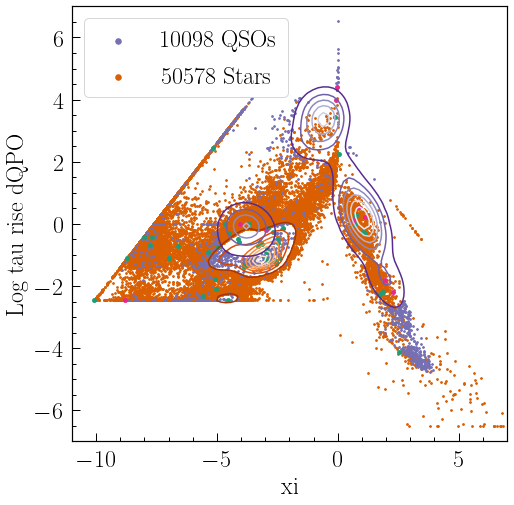

In [39]:
lims = np.array([[-11,10], [-7,7]])
lims = lims.flatten()
levels = None
nlevel=1

fig, axis = plt.subplots(1,1,figsize=(8,8))

handles, labels = (0, 0)

contour_scatter(np.log10(final_df[tnmask]['xi']), np.log10(final_df[tnmask]['tau_rise_dqpo']), lims=lims, levels=levels, nlevel=nlevel, cmap='Oranges_r', color=csdark[1], kwargs_plot={'rasterized':True, 's':3}, ax=axis)
contour_scatter(np.log10(final_df[tpmask]['xi']), np.log10(final_df[tpmask]['tau_rise_dqpo']), lims=lims, levels=levels, nlevel=nlevel, cmap='Purples_r', color=csdark[2], kwargs_plot={'rasterized':True, 's':3}, ax=axis)  
#contour_scatter(np.log10(final_df[fnmask]['xi']), np.log10(final_df[fnmask]['tau_rise_dqpo']), lims=lims, levels=levels, nlevel=nlevel, cmap='Greens_r', color=csdark[0], kwargs_plot={'rasterized':True, 's':3}, ax=axis)
#contour_scatter(np.log10(final_df[fpmask]['xi']), np.log10(final_df[fpmask]['tau_rise_dqpo']), lims=lims, levels=levels, nlevel=nlevel, cmap='Reds_r', color=csdark[3], kwargs_plot={'rasterized':True, 's':3}, ax=axis)
axis.scatter(np.log10(final_df[fnmask]['xi']), np.log10(final_df[fnmask]['tau_rise_dqpo']), color=csdark[0], s=15)
axis.scatter(np.log10(final_df[fpmask]['xi']), np.log10(final_df[fpmask]['tau_rise_dqpo']), color=csdark[3], s=15)
axis.set_xlim(-11,7.0)
axis.set_ylim(-7.0,7.0)
axis.set_xlabel('xi')
axis.set_ylabel('Log tau rise dQPO')
axis.set_box_aspect(1)

handles = [plt.scatter([], [], color=csdark[2], s=30),plt.scatter([],[],color=csdark[1],s=30)]
labels  = [str(tpmask.sum())+' QSOs',str(tnmask.sum())+' Stars']
legend = axis.legend(handles, labels, loc='best')   

This is a bit of a mess. Weixiang would need to comment.

[0.   0.02 0.04 0.06 0.08 0.1  0.12 0.14]
[0.    0.025 0.05  0.075 0.1   0.125 0.15  0.175]


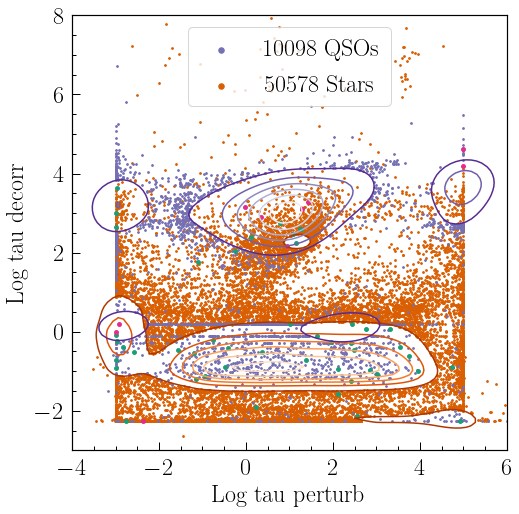

In [40]:
lims = np.array([[-5,7], [-3,7]])
lims = lims.flatten()
levels = None
nlevel=1

fig, axis = plt.subplots(1,1,figsize=(8,8))

handles, labels = (0, 0)

contour_scatter(np.log10(final_df[tnmask]['tau_perturb']), np.log10(final_df[tnmask]['tau_decorr']), lims=lims, levels=levels, nlevel=nlevel, cmap='Oranges_r', color=csdark[1], kwargs_plot={'rasterized':True, 's':3}, ax=axis)
contour_scatter(np.log10(final_df[tpmask]['tau_perturb']), np.log10(final_df[tpmask]['tau_decorr']), lims=lims, levels=levels, nlevel=nlevel, cmap='Purples_r', color=csdark[2], kwargs_plot={'rasterized':True, 's':3}, ax=axis)  
#contour_scatter(np.log10(final_df[fnmask]['tau_perturb']), np.log10(final_df[fnmask]['tau_decorr']), lims=lims, levels=levels, nlevel=nlevel, cmap='Greens_r', color=csdark[0], kwargs_plot={'rasterized':True, 's':3}, ax=axis)
#contour_scatter(np.log10(final_df[fpmask]['tau_perturb']), np.log10(final_df[fpmask]['tau_decorr']), lims=lims, levels=levels, nlevel=nlevel, cmap='Reds_r', color=csdark[3], kwargs_plot={'rasterized':True, 's':3}, ax=axis)
axis.scatter(np.log10(final_df[fnmask]['tau_perturb']), np.log10(final_df[fnmask]['tau_decorr']), color=csdark[0], s=15)
axis.scatter(np.log10(final_df[fpmask]['tau_perturb']), np.log10(final_df[fpmask]['tau_decorr']), color=csdark[3], s=15)
axis.set_xlim(-4.0,6.0)
axis.set_ylim(-3.0,8.0)
axis.set_xlabel('Log tau perturb')
axis.set_ylabel('Log tau decorr')
axis.set_box_aspect(1)

handles = [plt.scatter([], [], color=csdark[2], s=30),plt.scatter([],[],color=csdark[1],s=30)]
labels  = [str(tpmask.sum())+' QSOs',str(tnmask.sum())+' Stars']
legend = axis.legend(handles, labels, loc='best')   

Same here.

[0.   0.08 0.16 0.24 0.32 0.4  0.48 0.56]
[0.   0.06 0.12 0.18 0.24 0.3  0.36 0.42 0.48]


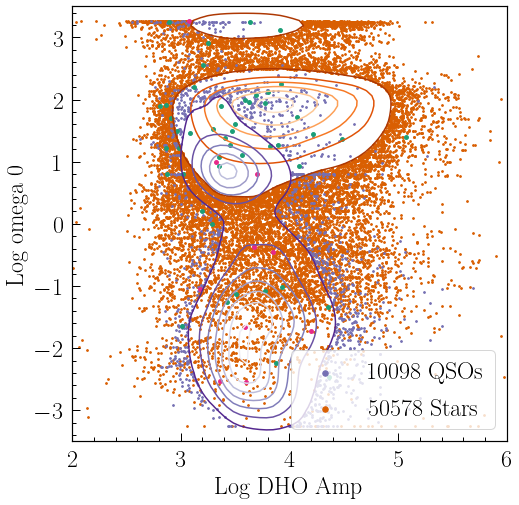

In [41]:
lims = np.array([[1,7], [-4,4]])
lims = lims.flatten()
levels = None
nlevel=1

fig, axis = plt.subplots(1,1,figsize=(8,8))

handles, labels = (0, 0)

contour_scatter(np.log10(final_df[tnmask]['amp']), np.log10(final_df[tnmask]['omega_0']), lims=lims, levels=levels, nlevel=nlevel, cmap='Oranges_r', color=csdark[1], kwargs_plot={'rasterized':True, 's':3}, ax=axis)
contour_scatter(np.log10(final_df[tpmask]['amp']), np.log10(final_df[tpmask]['omega_0']), lims=lims, levels=levels, nlevel=nlevel, cmap='Purples_r', color=csdark[2], kwargs_plot={'rasterized':True, 's':3}, ax=axis)  
#contour_scatter(np.log10(final_df[fnmask]['amp']), final_df[fnmask]['omega_0'], lims=lims, levels=levels, nlevel=nlevel, cmap='Greens_r', color=csdark[0], kwargs_plot={'rasterized':True, 's':3}, ax=axis)
#contour_scatter(np.log10(final_df[fpmask]['amp']), final_df[fpmask]['omega_0'], lims=lims, levels=levels, nlevel=nlevel, cmap='Reds_r', color=csdark[3], kwargs_plot={'rasterized':True, 's':3}, ax=axis)
axis.scatter(np.log10(final_df[fnmask]['amp']), np.log10(final_df[fnmask]['omega_0']), color=csdark[0], s=15)
axis.scatter(np.log10(final_df[fpmask]['amp']), np.log10(final_df[fpmask]['omega_0']), color=csdark[3], s=15)
axis.set_xlim(2.0,6.0)
axis.set_ylim(-3.5,3.5)
axis.set_xlabel('Log DHO Amp')
axis.set_ylabel('Log omega 0')
axis.set_box_aspect(1)

handles = [plt.scatter([], [], color=csdark[2], s=30),plt.scatter([],[],color=csdark[1],s=30)]
labels  = [str(tpmask.sum())+' QSOs',str(tnmask.sum())+' Stars']
legend = axis.legend(handles, labels, loc='best')   

One subset of quasars is clearly distinct in omega_0 (as it was in `xi`).  This likely reflects the difference between over and underdamped systems (see Moreno et al. 2019) and is potentially as interesting for science as it is for classification.

Look at 2 of the most useful variability parameters aside from the DHO ones.  These are the von Neuman ratio and log(chi2 falseQSO) from Butler & Bloom (2011)

In [42]:
print(final_df['lcNonPeriodic[26]_i'].min(), final_df['lcNonPeriodic[26]_i'].max())
print(final_df['lcNonPeriodic[26]_i'].quantile([0.1,0.90]))
print(final_df['lcNonPeriodic[15]_i'].min(), final_df['lcNonPeriodic[15]_i'].max())
print(final_df['lcNonPeriodic[15]_i'].quantile([0.1,0.90]))

0.06728735 3.10561601
0.1    0.914635
0.9    2.269150
Name: lcNonPeriodic[26]_i, dtype: float64
-1.20237846 4.48016797
0.1   -0.064880
0.9    1.198925
Name: lcNonPeriodic[15]_i, dtype: float64


[0.  0.5 1.  1.5 2.  2.5 3.  3.5]
[0.  0.2 0.4 0.6 0.8 1.  1.2 1.4 1.6]


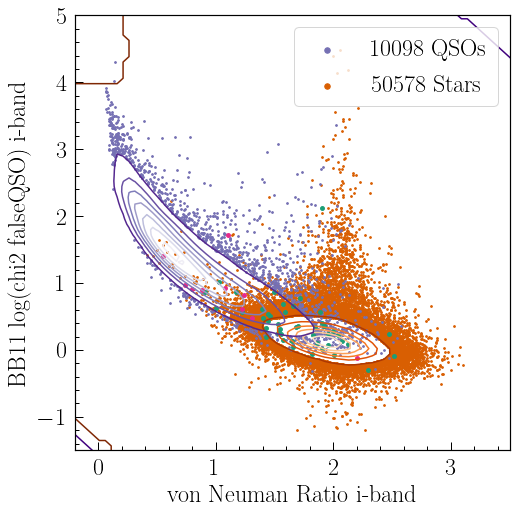

In [43]:
lims = np.array([[-1,4], [-2,6]])
lims = lims.flatten()
levels = None
nlevel=1

fig, axis = plt.subplots(1,1,figsize=(8,8))

handles, labels = (0, 0)

contour_scatter(final_df[tnmask]['lcNonPeriodic[26]_i'], final_df[tnmask]['lcNonPeriodic[15]_i'], lims=lims, levels=levels, nlevel=nlevel, cmap='Oranges_r', color=csdark[1], kwargs_plot={'rasterized':True, 's':3}, ax=axis)
contour_scatter(final_df[tpmask]['lcNonPeriodic[26]_i'], final_df[tpmask]['lcNonPeriodic[15]_i'], lims=lims, levels=levels, nlevel=nlevel, cmap='Purples_r', color=csdark[2], kwargs_plot={'rasterized':True, 's':3}, ax=axis)  
#contour_scatter(final_df[fnmask]['lcNonPeriodic[26]_i'], final_df[fnmask]['lcNonPeriodic[15]_i'], lims=lims, levels=levels, nlevel=nlevel, cmap='Greens_r', color=csdark[0], kwargs_plot={'rasterized':True, 's':3}, ax=axis)
#contour_scatter(final_df[fpmask]['lcNonPeriodic[26]_i'], final_df[fpmask]['lcNonPeriodic[15]_i'], lims=lims, levels=levels, nlevel=nlevel, cmap='Reds_r', color=csdark[3], kwargs_plot={'rasterized':True, 's':3}, ax=axis)
axis.scatter(final_df[fnmask]['lcNonPeriodic[26]_i'], final_df[fnmask]['lcNonPeriodic[15]_i'], color=csdark[0], s=15)
axis.scatter(final_df[fpmask]['lcNonPeriodic[26]_i'], final_df[fpmask]['lcNonPeriodic[15]_i'], color=csdark[3], s=15)
axis.set_xlim(-0.2,3.5)
axis.set_ylim(-1.5,5.0)
axis.set_xlabel('von Neuman Ratio i-band')
axis.set_ylabel('BB11 log(chi2 falseQSO) i-band')
axis.set_box_aspect(1)

handles = [plt.scatter([], [], color=csdark[2], s=30),plt.scatter([],[],color=csdark[1],s=30)]
labels  = [str(tpmask.sum())+' QSOs',str(tnmask.sum())+' Stars']
legend = axis.legend(handles, labels, loc='best')   

Very clear separation here.  It is obvious why the classification works so well.  Really just need this and a single color.  Of course, that's for pretty bright objects.  It is interesting that the stars classified as QSO (teal) are all solidly in the star space here.

### ---

## Now do the same for the XMM data (which includes X-ray, but excludes variability)

In [44]:
## commonly used modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import os, sys
import yaml

pd.set_option('display.max_columns', 999)
mpl.rc_file('https://raw.githubusercontent.com/ywx649999311/configs/master/viz/yuBasic.rc')

## Data challenge root data dir
data_dir = "/home/idies/workspace/Temporary/ywx649999311/LSST_AGN/Class_Training/DC/"

In [45]:
!ls "/home/idies/workspace/Temporary/ywx649999311/LSST_AGN/Class_Training/DC/"

ForcedSourceTable.parquet  s82MultiWavelengthTable.parquet
ObjectTable.parquet	   s82ObjectTable.parquet
SourceTable.parquet	   s82SourceTable.parquet
cutouts			   xmmlssMultiWavelengthTable.parquet
lc_feats.yml		   xmmlssObjectTable.parquet
mw_cols.yml		   xmmlssSourceTable.parquet


In [46]:
# It will take up to ~30 secs
object_df2 = pd.read_parquet(os.path.join(data_dir, 'xmmlssObjectTable.parquet'))
object_df2.head(3)

,ra,dec,psPm_ra,psPm_dec,psParallax,psFlux_u,psFlux_g,psFlux_r,psFlux_i,psFlux_z,psFlux_y,psFluxErr_u,psFluxErr_g,psFluxErr_r,psFluxErr_i,psFluxErr_z,psFluxErr_y,bdFlux_u,bdFlux_g,bdFlux_r,bdFlux_i,bdFlux_z,bdFlux_y,bdFluxErr_u,bdFluxErr_g,bdFluxErr_r,bdFluxErr_i,bdFluxErr_z,bdFluxErr_y,psMag_u,psMag_g,psMag_r,psMag_i,psMag_z,psMag_y,psMagErr_u,psMagErr_g,psMagErr_r,psMagErr_i,psMagErr_z,psMagErr_y,bdMag_u,bdMag_g,bdMag_r,bdMag_i,bdMag_z,bdMag_y,bdMagErr_u,bdMagErr_g,bdMagErr_r,bdMagErr_i,bdMagErr_z,bdMagErr_y,extendedness_u,extendedness_g,extendedness_r,extendedness_i,extendedness_z,extendedness_y,stdColor_0,stdColor_1,stdColor_2,stdColor_3,stdColor_4,stdColorErr_0,stdColorErr_1,stdColorErr_2,stdColorErr_3,stdColorErr_4,class,photoZ_pest,z,flags_u,flags_g,flags_r,flags_i,flags_z,flags_y,lcPeriodic[0]_g,lcPeriodic[0]_r,lcPeriodic[0]_i,lcPeriodic[1]_g,lcPeriodic[1]_r,lcPeriodic[1]_i,lcPeriodic[2]_g,lcPeriodic[2]_r,lcPeriodic[2]_i,lcPeriodic[3]_g,lcPeriodic[3]_r,lcPeriodic[3]_i,lcPeriodic[4]_u,lcPeriodic[4]_g,lcPeriodic[4]_r,lcPeriodic[4]_i,lcPeriodic[4]_z,lcPeriodic[5]_u,lcPeriodic[5]_g,lcPeriodic[5]_r,lcPeriodic[5]_i,lcPeriodic[5]_z,lcPeriodic[6]_u,lcPeriodic[6]_g,lcPeriodic[6]_r,lcPeriodic[6]_i,lcPeriodic[6]_z,lcPeriodic[7]_u,lcPeriodic[7]_g,lcPeriodic[7]_r,lcPeriodic[7]_i,lcPeriodic[7]_z,lcPeriodic[8]_u,lcPeriodic[8]_g,lcPeriodic[8]_r,lcPeriodic[8]_i,lcPeriodic[8]_z,lcPeriodic[9]_u,lcPeriodic[9]_g,lcPeriodic[9]_r,lcPeriodic[9]_i,lcPeriodic[9]_z,lcPeriodic[10]_u,lcPeriodic[10]_g,lcPeriodic[10]_r,lcPeriodic[10]_i,lcPeriodic[10]_z,lcPeriodic[11]_u,lcPeriodic[11]_g,lcPeriodic[11]_r,lcPeriodic[11]_i,lcPeriodic[11]_z,lcPeriodic[12]_u,lcPeriodic[12]_g,lcPeriodic[12]_r,lcPeriodic[12]_i,lcPeriodic[12]_z,lcPeriodic[13]_u,lcPeriodic[13]_g,lcPeriodic[13]_r,lcPeriodic[13]_i,lcPeriodic[13]_z,lcPeriodic[14]_u,lcPeriodic[14]_g,lcPeriodic[14]_r,lcPeriodic[14]_i,lcPeriodic[14]_z,lcPeriodic[15]_u,lcPeriodic[15]_g,lcPeriodic[15]_r,lcPeriodic[15]_i,lcPeriodic[15]_z,lcPeriodic[16]_u,lcPeriodic[16]_g,lcPeriodic[16]_r,lcPeriodic[16]_i,lcPeriodic[16]_z,lcPeriodic[17]_u,lcPeriodic[17]_g,lcPeriodic[17]_r,lcPeriodic[17]_i,lcPeriodic[17]_z,lcPeriodic[18]_u,lcPeriodic[18]_g,lcPeriodic[18]_r,lcPeriodic[18]_i,lcPeriodic[18]_z,lcPeriodic[19]_u,lcPeriodic[19]_g,lcPeriodic[19]_r,lcPeriodic[19]_i,lcPeriodic[19]_z,lcPeriodic[20]_u,lcPeriodic[20]_g,lcPeriodic[20]_r,lcPeriodic[20]_i,lcPeriodic[20]_z,lcPeriodic[21]_u,lcPeriodic[21]_g,lcPeriodic[21]_r,lcPeriodic[21]_i,lcPeriodic[21]_z,lcPeriodic[22]_u,lcPeriodic[22]_g,lcPeriodic[22]_r,lcPeriodic[22]_i,lcPeriodic[22]_z,lcPeriodic[23]_u,lcPeriodic[23]_g,lcPeriodic[23]_r,lcPeriodic[23]_i,lcPeriodic[23]_z,lcPeriodic[24]_u,lcPeriodic[24]_g,lcPeriodic[24]_r,lcPeriodic[24]_i,lcPeriodic[24]_z,lcPeriodic[25]_u,lcPeriodic[25]_g,lcPeriodic[25]_r,lcPeriodic[25]_i,lcPeriodic[25]_z,lcPeriodic[26]_u,lcPeriodic[26]_g,lcPeriodic[26]_r,lcPeriodic[26]_i,lcPeriodic[26]_z,lcPeriodic[27]_u,lcPeriodic[27]_g,lcPeriodic[27]_r,lcPeriodic[27]_i,lcPeriodic[27]_z,lcPeriodic[28]_u,lcPeriodic[28]_g,lcPeriodic[28]_r,lcPeriodic[28]_i,lcPeriodic[28]_z,lcPeriodic[29]_u,lcPeriodic[29]_g,lcPeriodic[29]_r,lcPeriodic[29]_i,lcPeriodic[29]_z,lcPeriodic[30]_u,lcPeriodic[30]_g,lcPeriodic[30]_r,lcPeriodic[30]_i,lcPeriodic[30]_z,lcPeriodic[31]_u,lcPeriodic[31]_g,lcPeriodic[31]_r,lcPeriodic[31]_i,lcPeriodic[31]_z,lcPeriodic[32]_u,lcPeriodic[32]_g,lcPeriodic[32]_r,lcPeriodic[32]_i,lcPeriodic[32]_z,lcNonPeriodic[0]_u,lcNonPeriodic[0]_g,lcNonPeriodic[0]_r,lcNonPeriodic[0]_i,lcNonPeriodic[0]_z,lcNonPeriodic[1]_u,lcNonPeriodic[1]_g,lcNonPeriodic[1]_r,lcNonPeriodic[1]_i,lcNonPeriodic[1]_z,lcNonPeriodic[2]_u,lcNonPeriodic[2]_g,lcNonPeriodic[2]_r,lcNonPeriodic[2]_i,lcNonPeriodic[2]_z,lcNonPeriodic[3]_u,lcNonPeriodic[3]_g,lcNonPeriodic[3]_r,lcNonPeriodic[3]_i,lcNonPeriodic[3]_z,lcNonPeriodic[4]_u,lcNonPeriodic[4]_g,lcNonPeriodic[4]_r,lcNonPeriodic[4]_i,lcNonPeriodic[4]_z,lcNonPeriodic[5]_u,lcNonPeriodic[5]_g,lcNonPeriodic[5]_r,lcNonPeriodic[5]_i,lcNonPeriodic[5]_z,lcNo

What the XMM area really brings to the table is the X-ray (and other multiwavelength data -- at the expense of not having variability data).  So, we read in those multiwavelength data and join it with the optical data.

In [47]:
mw_df = pd.read_parquet(os.path.join(data_dir, 'xmmlssMultiWavelengthTable.parquet'))

#Placeholders for what we'll define later.
mw_df['zch1']=0
mw_df['ch1ch2']=0

mw_df.head(3)

,xid,src2x,sb_flux,sb_fluxerr,hb_flux,hb_fluxerr,fb_flux,fb_fluxerr,galex_id,src2galex,fuv_mag,fuv_magerr,nuv_mag,nuv_magerr,hv_id,src2hv,vista_j_m_base_psfflux_mag,vista_h_m_base_psfflux_mag,vista_ks_m_base_psfflux_mag,vista_j_m_base_psfflux_magerr,vista_h_m_base_psfflux_magerr,vista_ks_m_base_psfflux_magerr,vista_j_m_slot_modelflux_mag,vista_h_m_slot_modelflux_mag,vista_ks_m_slot_modelflux_mag,vista_j_m_slot_modelflux_magerr,vista_h_m_slot_modelflux_magerr,vista_ks_m_slot_modelflux_magerr,vista_j_m_base_classificationextendedness_value,vista_h_m_base_classificationextendedness_value,vista_ks_m_base_classificationextendedness_value,vista_j_m_base_classificationextendedness_flag,vista_h_m_base_classificationextendedness_flag,vista_ks_m_base_classificationextendedness_flag,dd_id,src2dd,fluxaper2_3p6,fluxerraper2_3p6,fluxauto_3p6,fluxerrauto_3p6,fluxaper2_4p5,fluxerraper2_4p5,fluxauto_4p5,fluxerrauto_4p5,flag_3p6,flag_4p5,help_id,src2help,f_pacs_100,f_pacs_160,ferr_pacs_100_u,ferr_pacs_160_u,ferr_pacs_100_l,ferr_pacs_160_l,f_spire_250,f_spire_350,f_spire_500,ferr_spire_250_u,ferr_spire_350_u,ferr_spire_500_u,ferr_spire_250_l,ferr_spire_350_l,ferr_spire_500_l,zch1,ch1ch2
objectId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1247442,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,NaN,NaN,NaN,NaN,NaN,0,0.187427,19.288946,19.416696,19.556147,0.000906,0.00135,0.002204,19.435351,19.545590,19.708421,0.000907,0.001350,0.002207,0.0,0.0,0.0,0,0,0,0.0,0.510640,28.110237,1.481818,53.779175,2.137067,20.593480,1.192541,43.291680,1.769077,2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
1247443,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,NaN,NaN,NaN,NaN,NaN,0,0.163738,20.633419,20.869081,21.277299,0.002800,0.00508,0.010529,20.766197,21.012778,21.421572,0.002804,0.005096,0.010570,0.0,0.0,0.0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
1247446,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,NaN,NaN,NaN,NaN,NaN,0,0.104396,19.541832,19.698987,19.966568,0.001019,0.00140,0.002542,19.593121,19.759438,20.042042,0.001021,0.001408,0.002558,0.0,0.0,0.0,0,0,0,0.0,0.411098,19.690851,1.020808,17.658743,0.829542,13.409506,0.874556,12.073013,0.687755,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0


In [48]:
mw_df = object_df2.join(mw_df, how='left')
mw_df.head(3)

,ra,dec,psPm_ra,psPm_dec,psParallax,psFlux_u,psFlux_g,psFlux_r,psFlux_i,psFlux_z,psFlux_y,psFluxErr_u,psFluxErr_g,psFluxErr_r,psFluxErr_i,psFluxErr_z,psFluxErr_y,bdFlux_u,bdFlux_g,bdFlux_r,bdFlux_i,bdFlux_z,bdFlux_y,bdFluxErr_u,bdFluxErr_g,bdFluxErr_r,bdFluxErr_i,bdFluxErr_z,bdFluxErr_y,psMag_u,psMag_g,psMag_r,psMag_i,psMag_z,psMag_y,psMagErr_u,psMagErr_g,psMagErr_r,psMagErr_i,psMagErr_z,psMagErr_y,bdMag_u,bdMag_g,bdMag_r,bdMag_i,bdMag_z,bdMag_y,bdMagErr_u,bdMagErr_g,bdMagErr_r,bdMagErr_i,bdMagErr_z,bdMagErr_y,extendedness_u,extendedness_g,extendedness_r,extendedness_i,extendedness_z,extendedness_y,stdColor_0,stdColor_1,stdColor_2,stdColor_3,stdColor_4,stdColorErr_0,stdColorErr_1,stdColorErr_2,stdColorErr_3,stdColorErr_4,class,photoZ_pest,z,flags_u,flags_g,flags_r,flags_i,flags_z,flags_y,lcPeriodic[0]_g,lcPeriodic[0]_r,lcPeriodic[0]_i,lcPeriodic[1]_g,lcPeriodic[1]_r,lcPeriodic[1]_i,lcPeriodic[2]_g,lcPeriodic[2]_r,lcPeriodic[2]_i,lcPeriodic[3]_g,lcPeriodic[3]_r,lcPeriodic[3]_i,lcPeriodic[4]_u,lcPeriodic[4]_g,lcPeriodic[4]_r,lcPeriodic[4]_i,lcPeriodic[4]_z,lcPeriodic[5]_u,lcPeriodic[5]_g,lcPeriodic[5]_r,lcPeriodic[5]_i,lcPeriodic[5]_z,lcPeriodic[6]_u,lcPeriodic[6]_g,lcPeriodic[6]_r,lcPeriodic[6]_i,lcPeriodic[6]_z,lcPeriodic[7]_u,lcPeriodic[7]_g,lcPeriodic[7]_r,lcPeriodic[7]_i,lcPeriodic[7]_z,lcPeriodic[8]_u,lcPeriodic[8]_g,lcPeriodic[8]_r,lcPeriodic[8]_i,lcPeriodic[8]_z,lcPeriodic[9]_u,lcPeriodic[9]_g,lcPeriodic[9]_r,lcPeriodic[9]_i,lcPeriodic[9]_z,lcPeriodic[10]_u,lcPeriodic[10]_g,lcPeriodic[10]_r,lcPeriodic[10]_i,lcPeriodic[10]_z,lcPeriodic[11]_u,lcPeriodic[11]_g,lcPeriodic[11]_r,lcPeriodic[11]_i,lcPeriodic[11]_z,lcPeriodic[12]_u,lcPeriodic[12]_g,lcPeriodic[12]_r,lcPeriodic[12]_i,lcPeriodic[12]_z,lcPeriodic[13]_u,lcPeriodic[13]_g,lcPeriodic[13]_r,lcPeriodic[13]_i,lcPeriodic[13]_z,lcPeriodic[14]_u,lcPeriodic[14]_g,lcPeriodic[14]_r,lcPeriodic[14]_i,lcPeriodic[14]_z,lcPeriodic[15]_u,lcPeriodic[15]_g,lcPeriodic[15]_r,lcPeriodic[15]_i,lcPeriodic[15]_z,lcPeriodic[16]_u,lcPeriodic[16]_g,lcPeriodic[16]_r,lcPeriodic[16]_i,lcPeriodic[16]_z,lcPeriodic[17]_u,lcPeriodic[17]_g,lcPeriodic[17]_r,lcPeriodic[17]_i,lcPeriodic[17]_z,lcPeriodic[18]_u,lcPeriodic[18]_g,lcPeriodic[18]_r,lcPeriodic[18]_i,lcPeriodic[18]_z,lcPeriodic[19]_u,lcPeriodic[19]_g,lcPeriodic[19]_r,lcPeriodic[19]_i,lcPeriodic[19]_z,lcPeriodic[20]_u,lcPeriodic[20]_g,lcPeriodic[20]_r,lcPeriodic[20]_i,lcPeriodic[20]_z,lcPeriodic[21]_u,lcPeriodic[21]_g,lcPeriodic[21]_r,lcPeriodic[21]_i,lcPeriodic[21]_z,lcPeriodic[22]_u,lcPeriodic[22]_g,lcPeriodic[22]_r,lcPeriodic[22]_i,lcPeriodic[22]_z,lcPeriodic[23]_u,lcPeriodic[23]_g,lcPeriodic[23]_r,lcPeriodic[23]_i,lcPeriodic[23]_z,lcPeriodic[24]_u,lcPeriodic[24]_g,lcPeriodic[24]_r,lcPeriodic[24]_i,lcPeriodic[24]_z,lcPeriodic[25]_u,lcPeriodic[25]_g,lcPeriodic[25]_r,lcPeriodic[25]_i,lcPeriodic[25]_z,lcPeriodic[26]_u,lcPeriodic[26]_g,lcPeriodic[26]_r,lcPeriodic[26]_i,lcPeriodic[26]_z,lcPeriodic[27]_u,lcPeriodic[27]_g,lcPeriodic[27]_r,lcPeriodic[27]_i,lcPeriodic[27]_z,lcPeriodic[28]_u,lcPeriodic[28]_g,lcPeriodic[28]_r,lcPeriodic[28]_i,lcPeriodic[28]_z,lcPeriodic[29]_u,lcPeriodic[29]_g,lcPeriodic[29]_r,lcPeriodic[29]_i,lcPeriodic[29]_z,lcPeriodic[30]_u,lcPeriodic[30]_g,lcPeriodic[30]_r,lcPeriodic[30]_i,lcPeriodic[30]_z,lcPeriodic[31]_u,lcPeriodic[31]_g,lcPeriodic[31]_r,lcPeriodic[31]_i,lcPeriodic[31]_z,lcPeriodic[32]_u,lcPeriodic[32]_g,lcPeriodic[32]_r,lcPeriodic[32]_i,lcPeriodic[32]_z,lcNonPeriodic[0]_u,lcNonPeriodic[0]_g,lcNonPeriodic[0]_r,lcNonPeriodic[0]_i,lcNonPeriodic[0]_z,lcNonPeriodic[1]_u,lcNonPeriodic[1]_g,lcNonPeriodic[1]_r,lcNonPeriodic[1]_i,lcNonPeriodic[1]_z,lcNonPeriodic[2]_u,lcNonPeriodic[2]_g,lcNonPeriodic[2]_r,lcNonPeriodic[2]_i,lcNonPeriodic[2]_z,lcNonPeriodic[3]_u,lcNonPeriodic[3]_g,lcNonPeriodic[3]_r,lcNonPeriodic[3]_i,lcNonPeriodic[3]_z,lcNonPeriodic[4]_u,lcNonPeriodic[4]_g,lcNonPeriodic[4]_r,lcNonPeriodic[4]_i,lcNonPeriodic[4]_z,lcNonPeriodic[5]_u,lcNonPeriodic[5]_g,lcNonPeriodic[5]_r,lcNonPeriodic[5]_i,lcNonPeriodic[5]_z,lcNo

Let's remove the light curve columns.  

Also the Herschel, GALEX, and Parallax as thre isn't much data.  

That will give us the largest number of objects with a unique multiwavelength data set.

In [49]:
# remove light curve cols
# Also Herschel, GALEX, and Parallax as thre isn't much data
lc_cols = [col for col in mw_df.columns if (('Periodic')) in col]
cols2 = [col for col in mw_df.columns if ('spire') in col]
cols3 = [col for col in mw_df.columns if ('pacs') in col]
cols4 = [col for col in mw_df.columns if ('Parallax') in col]
cols5 = [col for col in mw_df.columns if ('nuv') in col]
cols6 = [col for col in mw_df.columns if ('fuv') in col]
cols7 = [col for col in mw_df.columns if ('galex') in col]
cols8 = [col for col in mw_df.columns if ('help') in col]
all_cols = lc_cols + cols2 + cols3 + cols4 + cols5 + cols6 + cols7 + cols8

In [50]:
mw_short_df = mw_df.drop(columns=all_cols, axis=1)

In [51]:
mw_short_df.info(verbose=True, show_counts=True)
#mw_short_df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Index: 9497 entries, 1247442 to 1268021
Data columns (total 119 columns):
 #    Column                                            Non-Null Count  Dtype  
---   ------                                            --------------  -----  
 0    ra                                                9497 non-null   float64
 1    dec                                               9497 non-null   float64
 2    psPm_ra                                           8159 non-null   float64
 3    psPm_dec                                          8159 non-null   float64
 4    psFlux_u                                          7099 non-null   float64
 5    psFlux_g                                          9213 non-null   float64
 6    psFlux_r                                          9248 non-null   float64
 7    psFlux_i                                          9267 non-null   float64
 8    psFlux_z                                          9244 non-null   float64
 9    ps

Again, drop columns that are limiting the number of objects we can look at (unless we impuse the missing values).

In [52]:
xmmlss_df = mw_short_df.drop(['photoZ_pest', 'flags_u', 'flags_g', 'flags_r', 'flags_i', 'flags_z', 'flags_y'], axis=1)

class_names, counts = np.unique(xmmlss_df['class'].values, return_counts=True)
dict(zip(class_names, counts))

Note that only a handful of objects have labels in the XMM-LSS area.  We'll store those labels and then drop those columns.  That way we'll have more data, it is just that most of it won't be labeled.

In [53]:
yclass_df2 = xmmlss_df.pop('class')
yregress_df2 = xmmlss_df.pop('z')

In [54]:
X2 = xmmlss_df.to_numpy()
yclass2 = yclass_df2.to_numpy()
yregress2 = yregress_df2.to_numpy()

Now drop NaNs

In [55]:
xmmlss_good_df = xmmlss_df.dropna()

In [56]:
xmmlss_good_df.info(verbose=True, show_counts=True)
#xmmlss_good_df.info(verbose=True) #Old Pandas

<class 'pandas.core.frame.DataFrame'>
Index: 1032 entries, 1263326 to 1268017
Data columns (total 110 columns):
 #    Column                                            Non-Null Count  Dtype  
---   ------                                            --------------  -----  
 0    ra                                                1032 non-null   float64
 1    dec                                               1032 non-null   float64
 2    psPm_ra                                           1032 non-null   float64
 3    psPm_dec                                          1032 non-null   float64
 4    psFlux_u                                          1032 non-null   float64
 5    psFlux_g                                          1032 non-null   float64
 6    psFlux_r                                          1032 non-null   float64
 7    psFlux_i                                          1032 non-null   float64
 8    psFlux_z                                          1032 non-null   float64
 9    ps

We don't have labels here, so instead we would do some clustering analysis.  But for now, let's just look at some color-color and multi-wavelength plots. Start with the same color-color plots as above.

In [57]:
#First define some IR colors
xmmlss_good_df.loc[:,['zch1']] = (22.5-np.log10(xmmlss_good_df['psFlux_z'])) - (22.5-np.log10(xmmlss_good_df['fluxauto_3p6']))
xmmlss_good_df.loc[:,['ch1ch2']] = (22.5-np.log10(xmmlss_good_df['fluxauto_3p6'])) - (22.5-np.log10(xmmlss_good_df['fluxauto_4p5']))

/home/idies/miniconda3/envs/py38/lib/python3.8/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [58]:
xmmlss_good_df.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Index: 1032 entries, 1263326 to 1268017
Data columns (total 110 columns):
 #    Column                                            Non-Null Count  Dtype  
---   ------                                            --------------  -----  
 0    ra                                                1032 non-null   float64
 1    dec                                               1032 non-null   float64
 2    psPm_ra                                           1032 non-null   float64
 3    psPm_dec                                          1032 non-null   float64
 4    psFlux_u                                          1032 non-null   float64
 5    psFlux_g                                          1032 non-null   float64
 6    psFlux_r                                          1032 non-null   float64
 7    psFlux_i                                          1032 non-null   float64
 8    psFlux_z                                          1032 non-null   float64
 9    ps

We'll see that these are mostly AGN/quasars (by virtue of the fact that we are requiring an X-ray detection).  So plotting the stars subsample from Stripe 82 for reference (in orange).

[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8]
[0.  0.5 1.  1.5 2.  2.5 3.  3.5 4. ]
[0.  0.2 0.4 0.6 0.8 1.  1.2 1.4 1.6]
[ 0.   1.5  3.   4.5  6.   7.5  9.  10.5]
[0.  0.3 0.6 0.9 1.2 1.5 1.8 2.1]
[ 0.  8. 16. 24. 32. 40. 48. 56. 64.]
[0.  0.4 0.8 1.2 1.6 2.  2.4 2.8 3.2]


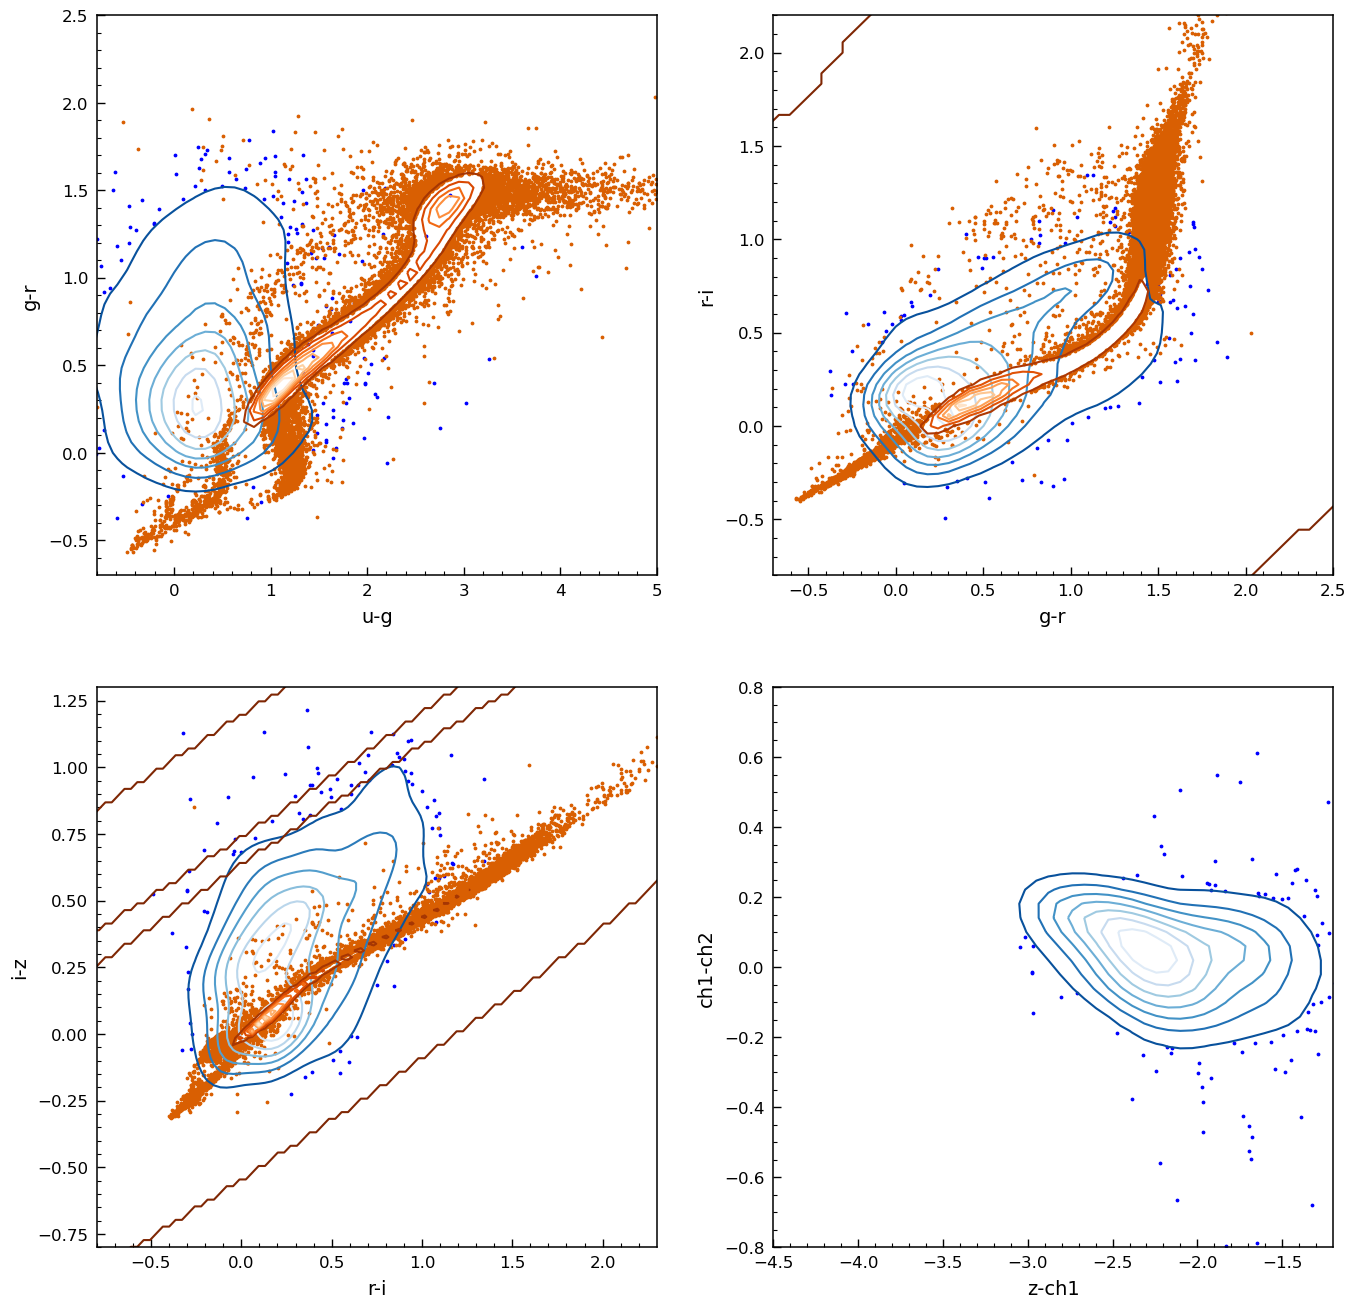

In [59]:
limsugr = np.array([[-2,8], [-2,4]])
limsugr = limsugr.flatten()
limsgri = np.array([[-2,4], [-2,3.5]])
limsgri = limsgri.flatten()
limsriz = np.array([[-1,2.5], [-1,1.5]])
limsriz = limsriz.flatten()
limszch1ch2 = np.array([[-5,2], [-2,2]])
limszch1ch2 = limszch1ch2.flatten()
levels = None
nlevel=1

# Make the figure:
#fig,ax = plt.figure(figsize=(8,8))
fig, ax = plt.subplots(2,2,figsize=(16,16))


handles, labels = (0, 0)
    
for i, axis in enumerate(ax.ravel()):

    if i==0: 
        contour_scatter(xmmlss_good_df['stdColor_0'], xmmlss_good_df['stdColor_1'], lims=limsugr, levels=levels, nlevel=nlevel, cmap='Blues_r', color='b', kwargs_plot={'rasterized':True, 's':3}, ax=axis)
        contour_scatter(final_df[tnmask]['stdColor_0'], final_df[tnmask]['stdColor_1'], lims=limsugr, levels=levels, nlevel=nlevel, cmap='Oranges_r', color=csdark[1], kwargs_plot={'rasterized':True, 's':3}, ax=axis)
        #contour_scatter(final_df[tpmask]['stdColor_0'], final_df[tpmask]['stdColor_1'], lims=limsugr, levels=levels, nlevel=nlevel, cmap='Purples_r', color=csdark[2], kwargs_plot={'rasterized':True, 's':3}, ax=axis)
        #contour_scatter(final_df[fnmask]['stdColor_0'], final_df[fnmask]['stdColor_1'], lims=limsugr, levels=levels, nlevel=nlevel, cmap='Greens_r', color=csdark[0], kwargs_plot={'rasterized':True, 's':3}, ax=axis)
        #contour_scatter(final_df[fpmask]['stdColor_0'], final_df[fpmask]['stdColor_1'], lims=limsugr, levels=levels, nlevel=nlevel, cmap='Reds_r', color=csdark[3], kwargs_plot={'rasterized':True, 's':3}, ax=axis)
        #axis.scatter(final_df[fnmask]['stdColor_0'], final_df[fnmask]['stdColor_1'], color=csdark[0], s=15)
        #axis.scatter(final_df[fpmask]['stdColor_0'], final_df[fpmask]['stdColor_1'], color=csdark[3], s=15)
        axis.set_xlim(-0.8,5)
        axis.set_ylim(-0.7,2.5)
        axis.set_xlabel('u-g')
        axis.set_ylabel('g-r')
        axis.set_box_aspect(1)
        
    if i==1:
        contour_scatter(xmmlss_good_df['stdColor_1'], xmmlss_good_df['stdColor_2'], lims=limsgri, levels=levels, nlevel=nlevel, cmap='Blues_r', color='b', kwargs_plot={'rasterized':True, 's':3}, ax=axis)
        contour_scatter(final_df[tnmask]['stdColor_1'], final_df[tnmask]['stdColor_2'], lims=limsgri, levels=levels, nlevel=nlevel, cmap='Oranges_r', color=csdark[1], kwargs_plot={'rasterized':True, 's':3}, ax=axis)
        #contour_scatter(final_df[tpmask]['stdColor_1'], final_df[tpmask]['stdColor_2'], lims=limsgri, levels=levels, nlevel=nlevel, cmap='Purples_r', color=csdark[2], kwargs_plot={'rasterized':True, 's':3}, ax=axis)
        #contour_scatter(final_df[fnmask]['stdColor_1'], final_df[fnmask]['stdColor_2'], lims=limsgri, levels=levels, nlevel=nlevel, cmap='Greens_r', color=csdark[0], kwargs_plot={'rasterized':True, 's':3}, ax=axis)
        #contour_scatter(final_df[fpmask]['stdColor_1'], final_df[fpmask]['stdColor_2'], lims=limsgri, levels=levels, nlevel=nlevel, cmap='Reds_r', color=csdark[3], kwargs_plot={'rasterized':True, 's':3}, ax=axis)
        #axis.scatter(final_df[fnmask]['stdColor_1'], final_df[fnmask]['stdColor_2'], color=csdark[0], s=15)
        #axis.scatter(final_df[fpmask]['stdColor_1'], final_df[fpmask]['stdColor_2'], color=csdark[3], s=15)
        axis.set_xlim(-0.7,2.5)
        axis.set_ylim(-0.8,2.2)
        axis.set_xlabel('g-r')
        axis.set_ylabel('r-i')
        axis.set_box_aspect(1)
        
    if i==2:
        contour_scatter(xmmlss_good_df['stdColor_2'], xmmlss_good_df['stdColor_3'], lims=limsriz, levels=levels, nlevel=nlevel, cmap='Blues_r', color='b', kwargs_plot={'rasterized':True, 's':3}, ax=axis)
        contour_scatter(final_df[tnmask]['stdColor_2'], final_df[tnmask]['stdColor_3'], lims=limsriz, levels=levels, nlevel=nlevel, cmap='Oranges_r', color=csdark[1], kwargs_plot={'rasterized':True, 's':3}, ax=axis)
        #contour_scatter(final_df[tpmask]['stdColor_2'], final_df[tpmask]['stdColor_3'], lims=limsriz, levels=levels, nlevel=nlevel, cmap='Purples_r', color=csdark[2], kwargs_plot={'rasterized':True, 's':3}, ax=axis)  
        #contour_scatter(final_df[fnmask]['stdColor_2'], final_df[fnmask]['stdColor_3'], lims=limsriz, levels=levels, nlevel=nlevel, cmap='Greens_r', color=csdark[0], kwargs_plot={'rasterized':True, 's':3}, ax=axis)
        #contour_scatter(final_df[fpmask]['stdColor_2'], final_df[fpmask]['stdColor_3'], lims=limsriz, levels=levels, nlevel=nlevel, cmap='Reds_r', color=csdark[3], kwargs_plot={'rasterized':True, 's':3}, ax=axis)
        #axis.scatter(final_df[fnmask]['stdColor_2'], final_df[fnmask]['stdColor_3'], color=csdark[0], s=15)
        #axis.scatter(final_df[fpmask]['stdColor_2'], final_df[fpmask]['stdColor_3'], color=csdark[3], s=15)
        axis.set_xlim(-0.8,2.3)
        axis.set_ylim(-0.8,1.3)
        axis.set_xlabel('r-i')
        axis.set_ylabel('i-z')
        axis.set_box_aspect(1)
        
    if i==3:
        contour_scatter(xmmlss_good_df['zch1'], xmmlss_good_df['ch1ch2'], lims=limszch1ch2, levels=levels, nlevel=nlevel, cmap='Blues_r', color='b', kwargs_plot={'rasterized':True, 's':3}, ax=axis)
        #contour_scatter(final_df[tpmask]['stdColor_2'], final_df[tpmask]['stdColor_3'], lims=limsriz, levels=levels, nlevel=nlevel, cmap='Purples_r', color=csdark[2], kwargs_plot={'rasterized':True, 's':3}, ax=axis)  
        #contour_scatter(final_df[fnmask]['stdColor_2'], final_df[fnmask]['stdColor_3'], lims=limsriz, levels=levels, nlevel=nlevel, cmap='Greens_r', color=csdark[0], kwargs_plot={'rasterized':True, 's':3}, ax=axis)
        #contour_scatter(final_df[fpmask]['stdColor_2'], final_df[fpmask]['stdColor_3'], lims=limsriz, levels=levels, nlevel=nlevel, cmap='Reds_r', color=csdark[3], kwargs_plot={'rasterized':True, 's':3}, ax=axis)
        #axis.scatter(final_df[fnmask]['stdColor_2'], final_df[fnmask]['stdColor_3'], color=csdark[0], s=15)
        #axis.scatter(final_df[fpmask]['stdColor_2'], final_df[fpmask]['stdColor_3'], color=csdark[3], s=15)
        axis.set_xlim(-4.5,-1.2)
        axis.set_ylim(-0.8,0.8)
        axis.set_xlabel('z-ch1')
        axis.set_ylabel('ch1-ch2')     
        axis.set_box_aspect(1)

    #if i==3:
        #axis.set_axis_off()
        ##handles = [plt.scatter([], [], color=csdark[1], s=30),plt.scatter([],[],color=csdark[2],s=30),plt.scatter([],[],color=csdark[3],s=30),plt.scatter([],[],color=csdark[0],s=50)]
        ##labels  = ['Stars as Stars (TN='+str(tnmask.sum())+')', 'QSOs as QSOs (TP='+str(tpmask.sum())+')', 'QSOs as Stars (FN='+str(fnmask.sum())+')', 'Stars as QSOs (FP='+str(fpmask.sum())+')']
        #handles = [plt.scatter([],[],color=csdark[2],s=30),plt.scatter([],[],color=csdark[3],s=30),plt.scatter([], [], color=csdark[1], s=30),plt.scatter([],[],color=csdark[0],s=30)]
        #labels  = ['QSOs as QSOs (TP='+str(tpmask.sum())+')', 'QSOs as Stars (FN='+str(fnmask.sum())+')', 'Stars as Stars (TN='+str(tnmask.sum())+')', 'Stars as QSOs (FP='+str(fpmask.sum())+')']
        #legend = axis.legend(handles, labels, loc='center') 

The color distribution of the blue objects (e.g., bimodal in riz plot) is such that it is pretty clear that these are dominated by AGN/quasars as might be expected for objects required to have X-ray.

Adding the Stripe 82 stars similarly makes this clear (note that the multi-wavelength data is not included for those objects, but other than the X-ray, it does exist).

What does this look like in the X-ray and VISTA?

[0.  0.4 0.8 1.2 1.6 2.  2.4 2.8]
[0.  0.4 0.8 1.2 1.6 2.  2.4 2.8 3.2]


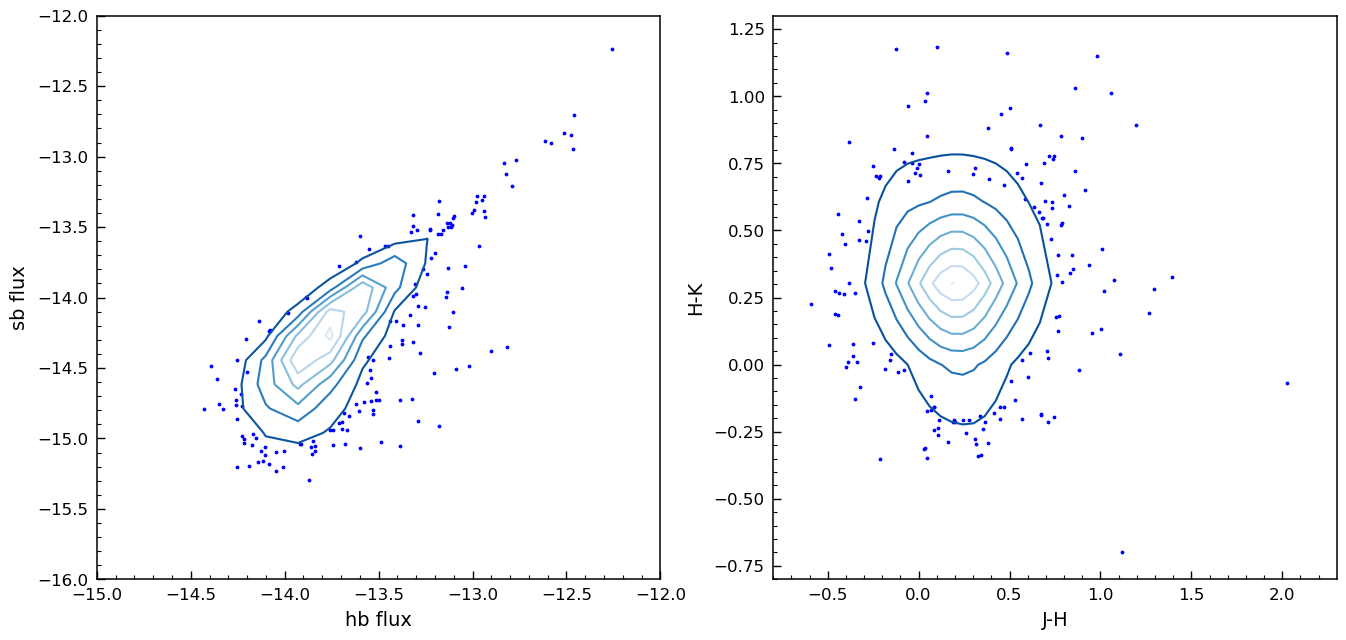

In [60]:
lims1 = np.array([[-22,-5], [-22,-5]])
lims1 = lims1.flatten()
lims2 = np.array([[-3,5], [-1,3]])
lims2 = limsgri.flatten()
lims3 = np.array([[-2,4], [-20,10]])
lims3 = lims3.flatten()
lims4 = np.array([[-20,10], [-20,10]])
lims4 = lims4.flatten()
levels = None
nlevel=1

# Make the figure:
#fig,ax = plt.figure(figsize=(8,8))
fig, ax = plt.subplots(1,2,figsize=(16,16))


handles, labels = (0, 0)
    
for i, axis in enumerate(ax.ravel()):

    if i==0: 
        contour_scatter(np.log10(xmmlss_good_df['hb_flux']), np.log10(xmmlss_good_df['sb_flux']), lims=lims1, levels=levels, nlevel=nlevel, cmap='Blues_r', color='b', kwargs_plot={'rasterized':True, 's':3}, ax=axis)
        #contour_scatter(final_df[tpmask]['stdColor_0'], final_df[tpmask]['stdColor_1'], lims=limsugr, levels=levels, nlevel=nlevel, cmap='Purples_r', color=csdark[2], kwargs_plot={'rasterized':True, 's':3}, ax=axis)
        #contour_scatter(final_df[fnmask]['stdColor_0'], final_df[fnmask]['stdColor_1'], lims=limsugr, levels=levels, nlevel=nlevel, cmap='Greens_r', color=csdark[0], kwargs_plot={'rasterized':True, 's':3}, ax=axis)
        #contour_scatter(final_df[fpmask]['stdColor_0'], final_df[fpmask]['stdColor_1'], lims=limsugr, levels=levels, nlevel=nlevel, cmap='Reds_r', color=csdark[3], kwargs_plot={'rasterized':True, 's':3}, ax=axis)
        #axis.scatter(final_df[fnmask]['stdColor_0'], final_df[fnmask]['stdColor_1'], color=csdark[0], s=15)
        #axis.scatter(final_df[fpmask]['stdColor_0'], final_df[fpmask]['stdColor_1'], color=csdark[3], s=15)
        axis.set_xlim(-15,-12)
        axis.set_ylim(-16,-12)
        axis.set_xlabel('hb flux')
        axis.set_ylabel('sb flux')
        axis.set_box_aspect(1)

    if i==1:
        contour_scatter(xmmlss_good_df['vista_j_m_base_psfflux_mag']-xmmlss_good_df['vista_h_m_base_psfflux_mag'], xmmlss_good_df['vista_h_m_base_psfflux_mag']-xmmlss_good_df['vista_ks_m_base_psfflux_mag'], lims=lims3, levels=levels, nlevel=nlevel, cmap='Blues_r', color='b', kwargs_plot={'rasterized':True, 's':3}, ax=axis)
        #contour_scatter(final_df[tpmask]['stdColor_2'], final_df[tpmask]['stdColor_3'], lims=limsriz, levels=levels, nlevel=nlevel, cmap='Purples_r', color=csdark[2], kwargs_plot={'rasterized':True, 's':3}, ax=axis)  
        #contour_scatter(final_df[fnmask]['stdColor_2'], final_df[fnmask]['stdColor_3'], lims=limsriz, levels=levels, nlevel=nlevel, cmap='Greens_r', color=csdark[0], kwargs_plot={'rasterized':True, 's':3}, ax=axis)
        #contour_scatter(final_df[fpmask]['stdColor_2'], final_df[fpmask]['stdColor_3'], lims=limsriz, levels=levels, nlevel=nlevel, cmap='Reds_r', color=csdark[3], kwargs_plot={'rasterized':True, 's':3}, ax=axis)
        #axis.scatter(final_df[fnmask]['stdColor_2'], final_df[fnmask]['stdColor_3'], color=csdark[0], s=15)
        #axis.scatter(final_df[fpmask]['stdColor_2'], final_df[fpmask]['stdColor_3'], color=csdark[3], s=15)
        axis.set_xlim(-0.8,2.3)
        axis.set_ylim(-0.8,1.3)
        axis.set_xlabel('J-H')
        axis.set_ylabel('H-K')
        axis.set_box_aspect(1)

    #if i==3:
        #axis.set_axis_off()
        ##handles = [plt.scatter([], [], color=csdark[1], s=30),plt.scatter([],[],color=csdark[2],s=30),plt.scatter([],[],color=csdark[3],s=30),plt.scatter([],[],color=csdark[0],s=50)]
        ##labels  = ['Stars as Stars (TN='+str(tnmask.sum())+')', 'QSOs as QSOs (TP='+str(tpmask.sum())+')', 'QSOs as Stars (FN='+str(fnmask.sum())+')', 'Stars as QSOs (FP='+str(fpmask.sum())+')']
        #handles = [plt.scatter([],[],color=csdark[2],s=30),plt.scatter([],[],color=csdark[3],s=30),plt.scatter([], [], color=csdark[1], s=30),plt.scatter([],[],color=csdark[0],s=30)]
        #labels  = ['QSOs as QSOs (TP='+str(tpmask.sum())+')', 'QSOs as Stars (FN='+str(fnmask.sum())+')', 'Stars as Stars (TN='+str(tnmask.sum())+')', 'Stars as QSOs (FP='+str(fpmask.sum())+')']
        #legend = axis.legend(handles, labels, loc='center') 

OK, so this XMM section was really just some exploratory data analysis.  But it demonstrates how important multi-wavelength data will be.  Simply having an X-ray detection significantly increases the AGN classification probability.

---

## Experiment in Transfer Learning with an Autoencoder

Next up:  Take the features of the Stripe 82 data and build an autoencoder with them.  For now I'm using all of the features, but we could use the results of the RF to indentify just the most important ones.

This is a project that I've given to a senior thesis student, so is beyond the scope of this data challenge.  However, I thought it worthwhile to describe what we are trying to do here and start writing some code.

In short, we are trying to do what is illustrated in Geron's Figure 17-6.  We'll build an autoencoder and train it using all of the Stripe 82 data.  Then we'll throw away the top (decoding) layers and keep just the bottom (encoding) layers.  We'll then use that as a basis for a classification algorithm using the labeled data.  I think of this as sort of like doing a clustering analysis on all of the data, finding groups that we don't know how to label, then taking those groups and labeling them.  Then new objects can be sorted into those group (and thuys labeled).

Start by building a stacked Autoencoder with 3 hidden layers and 1 output layer.

The next code block is just an example of how we'd build an autoencoder for imaging data (specifically 28x28 images).

But that's not what we have.  Rather we have tabular data, so that gets handled differently.  First let's see what the shape of that tabular data is.

In [61]:
print(final_df.shape)

(60733, 378)


In [62]:
Xclasstrain.shape

(45549, 378)

So what we need is an autoencoder for table data that has 371 columns.

This next cell follows the example from
https://blog.keras.io/building-autoencoders-in-keras.html

It runs, but I have commented it out since it takes a long time to run and I'm not clear on is how one then takes the encoded part and uses that as the basis for a classifier.  I'll have to leave that to my student.

But basically, it is running the autoencoder on the training data, validated using the test data.

This next cell is similar to that above, but now using the framework from Geron's book.  See
https://github.com/gtrichards/PHYS_440_540/blob/master/notebooks/TensorFlowCodeOnly.ipynb
        
Where this structure should make it easier to add something like this on top of the pre-trained encoder part

```
model = keras.models.Sequential() #Instantiate a sequential model
model.add(keras.layers.Flatten(input_shape=[28, 28])) #Define the input layer
model.add(keras.layers.Dense(300, activation="relu")) #First hidden layer
model.add(keras.layers.Dense(100, activation="relu")) #Second hidden layer
model.add(keras.layers.Dense(10, activation="softmax")) #Output layer

```

Except here we have just 2 categories, instead of 10, so we'd use a `sigmoid` activation function instead of `softmax` and `loss="binary_crossentropy"`.

So, now we have an autoencoder trained on all the training data and validated on the test data.  I'm not sure that that is exactly what we want to do as I thought that the point of the autoencoder was to use ALL of the data (without needing labels), but this will do to get us started.

---

Now following the example at
https://machinelearningmastery.com/autoencoder-for-classification/

This will take a long time if using all 371 features, so let's just use the top 50 according to the RF above.

In [63]:
top90 = importances.sort_values(ascending=False)[:90]

In [64]:
top90_df = transfer_df.filter(top90.index)

In [65]:
top90_df.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Index: 60733 entries, 0271390 to 1467484
Data columns (total 90 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   lcNonPeriodic[26]_g  60733 non-null  float64
 1   lcNonPeriodic[26]_r  60733 non-null  float64
 2   lcNonPeriodic[26]_i  60733 non-null  float64
 3   lcNonPeriodic[25]_g  60733 non-null  float64
 4   lcPeriodic[4]_i      60733 non-null  float64
 5   stdColor_0           60733 non-null  float64
 6   lcNonPeriodic[9]_r   60733 non-null  float64
 7   lcNonPeriodic[19]_r  60733 non-null  float64
 8   lcNonPeriodic[28]_r  60733 non-null  float64
 9   lcPeriodic[4]_r      60733 non-null  float64
 10  lcNonPeriodic[25]_r  60733 non-null  float64
 11  lcPeriodic[8]_g      60733 non-null  float64
 12  lcNonPeriodic[25]_i  60733 non-null  float64
 13  lcNonPeriodic[19]_i  60733 non-null  float64
 14  lcPeriodic[8]_r      60733 non-null  float64
 15  lcNonPeriodic[13]_g  60733 non-nu

In [66]:
ytrans = transfer_df.pop('class').to_numpy()
Xtrans = top90_df.to_numpy()

In [67]:
Xtranstrain, Xtranstest, ytranstrain, ytranstest = train_test_split(Xtrans, ytrans)

In [68]:
# number of input columns
n_inputs = Xtrans.shape[1]

In [70]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.utils import plot_model

In [71]:
# define encoder
visible = Input(shape=(n_inputs,))
# encoder level 1
e = Dense(n_inputs*2)(visible)
e = BatchNormalization()(e)
e = LeakyReLU()(e)
# encoder level 2
e = Dense(n_inputs)(e)
e = BatchNormalization()(e)
e = LeakyReLU()(e)
# bottleneck
#n_bottleneck = n_inputs
n_bottleneck = round(float(n_inputs) / 2.0)
bottleneck = Dense(n_bottleneck)(e)
# define decoder, level 1
d = Dense(n_inputs)(bottleneck)
d = BatchNormalization()(d)
d = LeakyReLU()(d)
# decoder level 2
d = Dense(n_inputs*2)(d)
d = BatchNormalization()(d)
d = LeakyReLU()(d)
# output layer
output = Dense(n_inputs, activation='linear')(d)
# define autoencoder model
model = Model(inputs=visible, outputs=output)
# compile autoencoder model
model.compile(optimizer='adam', loss='mse')
# plot the autoencoder
plot_model(model, 'autoencoder_no_compress.png', show_shapes=True)
# fit the autoencoder model to reconstruct input
history = model.fit(Xtranstrain, Xtranstrain, epochs=2, batch_size=16, verbose=2, validation_data=(Xtranstest,Xtranstest))

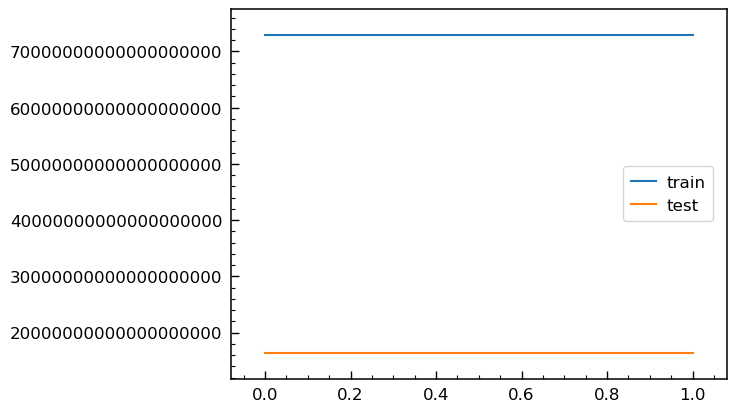

In [73]:
from matplotlib import pyplot
# plot loss
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()
# define an encoder model (without the decoder)
encoder = Model(inputs=visible, outputs=bottleneck)
#plot_model(encoder, 'encoder_no_compress.png', show_shapes=True)
# save the encoder to file
encoder.save('encoder.h5')

It is not obvious that this works and it takes a LONG time.  So I have limited it to just 2 epochs for illustration and will proceed below as if it worked!

Now we'll use that as the basis for a Logistic Regression Classifier.

In [74]:
# load the model from file
encoder = keras.models.load_model('encoder.h5')

In [77]:
# encode the train data
Xtranstrain_encode = encoder.predict(Xtranstrain)
# encode the test data
Xtranstest_encode = encoder.predict(Xtranstest)

In [78]:
# define a model for classification
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
# fit the model on the training set
model.fit(Xtranstrain_encode, ytranstrain)
# make predictions on the test set
ytranspred = model.predict(Xtranstest_encode)

In [79]:
acc = accuracy_score(ytranstest, ytranspred)
print(acc)

0.8339699683877766


How does this compare to the 99.5% accuracy we got from the RF?

Not as good, just 83%, but running for more epochs should improve things.

So, there is no point running on the blinded data set, but there is obviously work to be done to try to optimize this approach.

What if we used it at the input to the same RF classifier?

In [80]:
rfc2 = RandomForestClassifier(n_estimators=100, max_features='auto', n_jobs=-1)
rfc2.fit(Xtranstrain_encode,ytranstrain)
ytranspred2 = rfc2.predict(Xtranstest_encode)
acc2 = accuracy_score(ytranstest, ytranspred2)
print(acc2)

0.9631849315068494


That gives 96%, which is more promising.  I'll see what happens if I let it run for 100+ epochs.

---

As you can see, this is a work in progress.  
Here are some resources that we can look to for help figuring out the next steps:
    
https://keras.io/guides/functional_api/
https://blog.keras.io/building-autoencoders-in-keras.html
https://www.tensorflow.org/tutorials/images/transfer_learning_with_hub
https://www.tensorflow.org/guide/keras/sequential_model    
https://machinelearningmastery.com/autoencoder-for-classification/